In [1]:
#
# 2017-08-31
#
# XGB - решение - дурняк, но работает
#
#
#

In [2]:
import sys, os, math, datetime
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt


In [3]:
def dataClean( df ) :
    def cn (cc) : 
        cc = np.reshape(cc.values,(len(df)))
        return([jj for jj,dd in enumerate(cc.tolist()) if dd ])
    ##df=df.fillna(0.0)
    badly = np.zeros((len(df)),dtype=np.int32)
    ##cols  = df.columns.tolist()
    ##print(cols)
    for ii,nn in enumerate(df.columns.tolist()) :
        
        if (ii==0) and (nn.startswith('Chloro')) : # Chlorophyl
            cc = ((df[[ii]]<0.0) | (df[[ii]]>1.0))
            df.iloc[cn(cc),ii] = 0.0
            #badly[cn(cc)] += 1
        
        if (ii==1) and (nn.startswith('Depth')) : 
            cc = (df[[ii]]> 0.0);      df.iloc[cn(cc),ii] = -df.iloc[cn(cc),ii]
            cc = (df[[ii]]< -10000.0); df.iloc[cn(cc),ii] = -10000.0
            badly[cn(cc)] += 1
        
        if (ii==3) and (nn.startswith('Eastward')) :
            cc = (df[[ii]]< 0.0);      df.iloc[cn(cc),ii] = 0.0
            cc = (df[[ii]]> 5.0);      df.iloc[cn(cc),ii] = 5.0
            badly[cn(cc)] += 1
        
        if (ii==4) and (nn.startswith('Latitude')) :
            cc = (df[[ii]]< -90.0);      df.iloc[cn(cc),ii] = -90.0; badly[cn(cc)] += 1
            cc = (df[[ii]]>  90.0);      df.iloc[cn(cc),ii] =  90.0; badly[cn(cc)] += 1
        
        if (ii==5) and (nn.startswith('Longitude')) :
            cc = (df[[ii]]< -180.0);      df.iloc[cn(cc),ii] = -180.0; badly[cn(cc)] += 1
            cc = (df[[ii]]>  180.0);      df.iloc[cn(cc),ii] =  180.0; badly[cn(cc)] += 1
        
        if (ii==6) and (nn.startswith('Northward')) :
            cc = (df[[ii]]< 0.0);      df.iloc[cn(cc),ii] = 0.0
            cc = (df[[ii]]> 5.0);      df.iloc[cn(cc),ii] = 5.0
            badly[cn(cc)] += 1
        
        if (ii==7) and (nn.startswith('Oceanic')) : 
            cc = (df[[ii]]> 0.0);      df.iloc[cn(cc),ii] = -df.iloc[cn(cc),ii]
            cc = (df[[ii]]< -10000.0); df.iloc[cn(cc),ii] = -10000.0
            badly[cn(cc)] += 1
        
        if (ii==8) and (nn.startswith('SOG')) : 
            cc = (df[[ii]]<  0.0);      df.iloc[cn(cc),ii] =  0.0; badly[cn(cc)] += 1
            cc = (df[[ii]]> 35.0);      df.iloc[cn(cc),ii] =  0.0; badly[cn(cc)] += 1
        
        if (ii==9) and (nn.startswith('Salinity')) : 
            cc = (df[[ii]]<  0.0);      df.iloc[cn(cc),ii] =  0.0; badly[cn(cc)] += 1
            #cc = (df[[ii]]> 35.0);      df.iloc[cn(cc),ii] =  0.0; badly[cn(cc)] += 1
        
        if (ii==10) and (nn.startswith('Sea')) : 
            cc = (df[[ii]]<  0.0);      df.iloc[cn(cc),ii] =  0.0; badly[cn(cc)] += 1
            #cc = (df[[ii]]> 35.0);      df.iloc[cn(cc),ii] =  0.0; badly[cn(cc)] += 1
        
        if (ii==11) and (nn.startswith('Speed')) : 
            cc = (df[[ii]]<  0.0);      df.iloc[cn(cc),ii] =  0.0; badly[cn(cc)] += 1
            cc = (df[[ii]]> 35.0);      df.iloc[cn(cc),ii] =  0.0; badly[cn(cc)] += 1

        if (ii==11) and (nn.startswith('Thermocline')) : 
            cc = (df[[ii]]<     0.0);      df.iloc[cn(cc),ii] =     0.0; badly[cn(cc)] += 1
            cc = (df[[ii]]>  5000.0);      df.iloc[cn(cc),ii] =  5000.0; badly[cn(cc)] += 1

        if (ii==15) and (nn.startswith('Water')) : 
            cc = (df[[ii]]<  -100.0);      df.iloc[cn(cc),ii] =     0.0; badly[cn(cc)] += 1
            #cc = (df[[ii]]>  5000.0);      df.iloc[cn(cc),ii] =  5000.0; badly[cn(cc)] += 1

    print(cc.sum(),badly.sum())
    return(badly)

In [4]:
# Читаем train список
train_list = pd.read_csv('../Data/training.txt', header=None)
train_list.columns=['trackfile','typing']

In [5]:
train_list.head()

,trackfile,typing
0,100047,trawler
1,100070,longliner
2,100080,seiner
3,100093,other
4,100144,trawler


In [6]:
y_class = train_list['typing'].unique().tolist(); y_class

['trawler', 'longliner', 'seiner', 'other', 'support']

In [7]:
# Читаем test список
test_list = pd.read_csv('../Data/testing.txt', header=None)
test_list.columns=['trackfile']
print 'test length:',len(test_list)
test_list.head()

test length: 1211


,trackfile
0,100015
1,100045
2,100060
3,100112
4,100131


In [1014]:
# Построение массива с данными по списку файлов

def buildX_old (file_list, nFiles=-1, maxSpeed=35.0, maxSOG=35.0, rWindow=5, hTimeMin=False, hTimeMax=False, fillOK=False) :
    
    
    for ii,ffile in enumerate(file_list) :
        if ii==nFiles : break
        xx = pd.read_csv(os.path.join('../Data/VesselTracks',str(ffile)+'.csv'))
        
        ##print(ii,ffile)
        
        # Small corrections: (latitude&longitude), timing
        
        xx = xx[(xx.Latitude >=-90.0)  & (xx.Latitude <= 90.0)];
        xx = xx[(xx.Longitude>=-180.0) & (xx.Longitude<=180.0)];
        
        xx['Time']  = xx[[1]]
        xx['sTime'] = np.abs(xx.Time.diff(-1)).fillna(0.0)
        xx['hTime'] = xx.sTime/3600.0
        
        if hTimeMin : 
            xx          = xx[xx.hTime>=hTimeMin]
            xx['sTime'] = np.abs(xx.Time.diff(-1)).fillna(0.0)
            xx['hTime'] = xx.sTime/3600.0
            
        havLa       = (0.5*(1.0-np.cos(-xx.Latitude.diff(-1)/180.0*math.pi))).fillna(0.0)
        lLongitude  = xx.Longitude+360.0
        havLo       = (0.5*(1.0-np.cos(-lLongitude.diff(-1)/180.0*math.pi))).fillna(0.0)

        cosLa       = (np.cos(xx.Latitude/180.0*math.pi)).fillna(0.0)

        hav         = (havLa+cosLa*cosLa.shift(-1)*havLo).fillna(0.0)
        dist = (2*6371.0*np.arcsin(np.sqrt(hav))).fillna(0.0)

        xx['Distance'] = dist
        xx['Speed']    = np.round((dist/1.852/xx.hTime).fillna(0.0),2)
        xx.loc[xx.Speed>maxSpeed,'Speed'] = maxSpeed
        
        if hTimeMax : 
            xx.sTime[xx.hTime<=hTimeMax] = 0.0
            xx.hTime[xx.hTime<=hTimeMax] = 0.0
        
        # rolling Speed
        rSOG      = xx.SOG.rolling(window=rWindow, min_periods=1).mean()
        rSOGmd    = xx.SOG.rolling(window=rWindow, min_periods=1).median()
        rSpeed    = xx.Speed.rolling(window=rWindow, min_periods=1).mean()
        rDistance = xx.Distance.rolling(window=rWindow, min_periods=1).mean()
        rTime     = xx.hTime.rolling(window=rWindow, min_periods=1).mean()
        rDTSpeed = (rDistance/rTime/1.852).fillna(0.0)
        
        xx['rSpeed'] = np.round(np.clip(rSpeed,0.0,maxSpeed),2)
        xx['rSOG']   = np.round(np.clip(rSOG,0.0,maxSpeed),2)
        xx['rSOGmd'] = np.round(np.clip(rSOGmd,0.0,maxSpeed),2)
        xx['rDTSpeed'] = np.round(np.clip(rDTSpeed,0.0,maxSpeed),2)
        
        xx.loc[xx.SOG>maxSOG,'SOG'] = xx.loc[xx.SOG>maxSOG,'rSOG']
        xx.loc[xx.SOG<0.0,'SOG']    = xx.loc[xx.SOG<0.0,'rSOG']

        if fillOK : xx = xx.fillna(fillOK)

        if (ii==0) : resAll = xx.copy()
        else       : resAll = resAll.append(xx.copy())

    ##print(trainAll.shape)
    return (resAll)

def buildY (file_list, y_classes) :
    
    trainIndex=file_list.copy()
    trainIndex['y'] = np.array(map(y_classes.index,trainIndex.typing.tolist()))
    return(trainIndex)

In [1593]:
# Построение массива с данными по списку файлов

def harvestDistance (Latitude, Longitude, R=6371.0) :
    havLa        = (0.5*(1.0-np.cos(-Latitude.diff(-1)/180.0*math.pi))).fillna(0.0)
    long1        = Longitude; long1[Longitude<0.0]  += 360.0;
    long2        = Longitude;
    long1, long2 = long1.diff(-1).fillna(0.0), long2.diff(-1).fillna(0.0)
    lLongitude   = np.array([long1.values, long2.values]).min(axis=0)
    havLo        = pd.Series(0.5*(1.0-np.cos(lLongitude/180.0*math.pi)))
    cosLa        = (np.cos(Latitude/180.0*math.pi)).fillna(0.0)
    hav          = (havLa+cosLa*cosLa.shift(-1)*havLo).fillna(0.0)
    dist         = (2*R*np.arcsin(np.sqrt(hav))).fillna(0.0)
    return (dist)
    
def buildX (file_list, nFiles=-1, maxSpeed=35.0, maxSOG=35.0, rWindow=5, nRolling=2, hTimeMin=False, hTimeMax=False, fillOK=False) :
    
    mile_sea = 1.852
    
    for ii,ffile in enumerate(file_list) :
        if ii==nFiles : break
        xx = pd.read_csv(os.path.join('../Data/VesselTracks',str(ffile)+'.csv'))
        
        ##print(ii,ffile)
        
        # Small corrections: (latitude&longitude), timing
        
        ##print 'try 100'
        xx = xx[(xx.Latitude >=-90.0)  & (xx.Latitude <= 90.0)];
        xx = xx[(xx.Longitude>=-180.0) & (xx.Longitude<=180.0)];
        
        xx['Time']  = xx[[1]]
        xx['sTime'] = np.abs(xx.Time.diff(-1)).fillna(0.0)
        xx['hTime'] = xx.sTime/3600.0
        
        if hTimeMin : 
            xx          = xx[xx.hTime>=hTimeMin]
            xx['sTime'] = np.abs(xx.Time.diff(-1)).fillna(0.0)
            xx['hTime'] = xx.sTime/3600.0
            
        xx['Distance'] = harvestDistance(xx.Latitude,xx.Longitude)
        xx['Speed']    = np.round((xx.Distance/mile_sea/xx.hTime).fillna(0.0),2)  # speed in knots
        
        
        # Small correction: speed outline ->> Latitude&Longitude
        
        if (len(xx.Speed[xx.Speed>maxSpeed])>0) :
            ##print 'try change'
            xy = xx.Speed.values;
            rrWindow = 10
            ##print 'try change', xx.TrackNumber[0], len(xy), len(xy[xy>maxSpeed]), xy[xy>maxSpeed].min(), xy[xy>maxSpeed].max()
            
            Latitude   = xx.Latitude.values
            Longitude  = xx.Longitude.values
            Longitude[Longitude<=-100.0]  += 360.0  # ???? danger operation
            rLatitude  = xx.Latitude.rolling(window=rrWindow, min_periods=1).median().values
            rLongitude = xx.Longitude.rolling(window=rrWindow, min_periods=1).median().values
            Latitude[xy>maxSpeed]   = rLatitude[xy>maxSpeed]
            Longitude[xy>maxSpeed]  = rLongitude[xy>maxSpeed]
            Longitude[Longitude>180.0]  = xx.Longitude[Longitude>180.0] #- 360.0
            distance   = harvestDistance(pd.Series(Latitude),pd.Series(Longitude))
            speed      = np.round((distance/mile_sea/xx.hTime).fillna(0.0),2)  # speed in knots
            if  len(speed>maxSpeed)==0 :
                ##print 'change'
                xx.Latitude  = Latitude
                xx.Longitude = Longitude
                xx.Distance  = distance
                xx.Speed     = speed
            else :
                ##print 'deleting'
                xx              = xx[xx.Speed<=maxSpeed]
                sTime           = np.abs(xx.Time.diff(-1)).fillna(0.0)
                xx['sTime']     = sTime
                xx['hTime']     = xx.sTime/3600.0
                xx['Distance']  = harvestDistance(xx.Latitude,xx.Longitude)
                xx['Speed']     = np.round((xx.Distance/mile_sea/xx.hTime).fillna(0.0),2)  # speed in knots
        
        xx.loc[xx.Longitude>180,'Longitude'] -= 360.0
        xx['Speed']    = np.round(np.clip(xx.Speed,0.0,maxSpeed),2)
        
        if hTimeMax : 
            xx.sTime[xx.hTime<=hTimeMax] = 0.0
            xx.hTime[xx.hTime<=hTimeMax] = 0.0
        
        # rolling Speeds (double, triple and etc)
        for jj in range(1,nRolling+1) :
            suffix    = '' if jj==1 else str(jj)
            rSOG      = xx.SOG.rolling(window=rWindow*jj, min_periods=1).mean()
            rSOGmd    = xx.SOG.rolling(window=rWindow*jj, min_periods=1).median()
            rSpeed    = xx.Speed.rolling(window=rWindow*jj, min_periods=1).mean()
            rDistance = xx.Distance.rolling(window=rWindow*jj, min_periods=1).mean()
            rTime     = xx.hTime.rolling(window=rWindow*jj, min_periods=1).mean()
            rDTSpeed = (rDistance/rTime/mile_sea).fillna(0.0)
            
            xx['rSpeed'+suffix] = np.round(np.clip(rSpeed,0.0,maxSpeed),2)
            xx['rSOG'+suffix]   = np.round(np.clip(rSOG,0.0,maxSpeed),2)
            xx['rSOGmd'+suffix] = np.round(np.clip(rSOGmd,0.0,maxSpeed),2)
            xx['rDTSpeed'+suffix] = np.round(np.clip(rDTSpeed,0.0,maxSpeed),2)

        xx.loc[xx.SOG<0.0,'SOG']    = xx.loc[xx.SOG<0.0,'rSOG']
            
        if fillOK : xx = xx.fillna(fillOK)

        if (ii==0) : resAll = xx.copy()
        else       : resAll = resAll.append(xx.copy())

    ##print(trainAll.shape)
    return (resAll)

def buildY (file_list, y_classes) :
    
    trainIndex=file_list.copy()
    trainIndex['y'] = np.array(map(y_classes.index,trainIndex.typing.tolist()))
    return(trainIndex)

In [544]:
print datetime.datetime.now()
trainAll_ = buildX(train_list['trackfile'].values.tolist(), nFiles=12) #, hTimeMin=5.0/3600);
temp      = '\tLatitudes: between {} and {} \n\tLongitudes: between {} and {} \n\tFiles={} Shapes={}'
print(temp.format(trainAll_.Latitude.min(), trainAll_.Latitude.max(), trainAll_.Longitude.min(), 
                  trainAll_.Longitude.max(), len(trainAll_.TrackNumber.unique()),  trainAll_.shape))
print datetime.datetime.now()
##len(trainAll_.TrackNumber.unique()),trainAll_.TrackNumber.unique(),trainAll_.tail()

2017-09-04 01:39:50.834822
	Latitudes: between -67.458415 and 56.720937 
	Longitudes: between -179.67688 and 179.980242 
	Files=12 Shapes=(68343, 19)
2017-09-04 01:39:51.104943


In [545]:
trainAll_.describe()

,TrackNumber,Time(seconds),Latitude,Longitude,SOG,oceanic depth,Chlorophyll Concentration,Salinity,Water Surface Elevation,Sea Temperature,Thermocline Depth,Eastward Water Velocity,Northward Water Velocity,Time,sTime,hTime,Distance,Speed,rSpeed
count,68343.000000,6.834300e+04,68343.000000,68343.000000,68343.000000,68343.000000,68343.000000,68343.000000,68343.000000,68343.000000,68343.000000,68343.000000,68343.000000,6.834300e+04,6.834300e+04,68343.000000,68343.000000,68343.000000,68343.000000
mean,100177.603003,3.823745e+06,39.738107,-19.413192,1.510658,-208.938823,-44208.527856,30.038326,-5.191575,4.830204,169.833471,-4.268868,-4.348623,3.823745e+06,1.355213e+03,0.376448,3.105737,2.578414,7.250289
std,79.937088,2.384120e+06,20.018974,79.004114,382.551771,421.545481,49663.762562,662.754271,662.521443,662.693920,667.332902,662.526826,662.526270,2.384120e+06,1.697947e+04,4.716520,133.617179,4.445773,11.243540
min,100047.000000,0.000000e+00,-67.458415,-179.676880,-99999.000000,-1532.000000,-99999.000000,-99999.000000,-99999.000000,-99999.000000,-99999.000000,-99999.000000,-99999.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,100093.000000,1.544225e+06,37.388433,-9.366658,0.000000,-76.000000,-99999.000000,34.000000,-1.760000,-0.800000,136.100000,-0.060000,-0.100000,1.544225e+06,6.100000e+01,0.016944,0.001481,0.010000,0.020000
50%,100144.000000,4.021559e+06,51.415543,8.310493,0.100000,-5.000000,0.145500,34.200000,-1.370000,1.400000,169.000000,0.150000,0.050000,4.021559e+06,4.050000e+02,0.112500,0.004308,0.050000,0.670000
75%,100277.000000,5.945117e+06,53.993879,8.709229,3.600000,0.000000,0.683000,34.700000,-0.010000,14.400000,173.800000,0.310000,0.150000,5.945117e+06,9.300000e+02,0.258333,0.360720,3.200000,9.910000
max,100287.000000,7.948470e+06,56.720937,179.980242,16.800000,132.000000,3.902200,35.800000,0.770000,31.300000,1109.600000,1.160000,1.040000,7.948470e+06,2.163149e+06,600.874722,12436.947142,35.000000,35.000000


In [1594]:
print datetime.datetime.now()
trainAll_ = buildX(train_list['trackfile'].values.tolist(), hTimeMin=2.0/(60.0*60.0));
temp      = '\tLatitudes: between {} and {} \n\tLongitudes: between {} and {} \n\tFiles={} Shapes={}'
print(temp.format(trainAll_.Latitude.min(), trainAll_.Latitude.max(), trainAll_.Longitude.min(), 
                  trainAll_.Longitude.max(), len(trainAll_.TrackNumber.unique()),  trainAll_.shape))
trainAll  = trainAll_
trainAll.to_csv('../Data/trainingAllNew3.csv',index=False)
del trainAll_
print datetime.datetime.now()

2017-09-06 02:53:58.619845


/home/boba/anaconda2/envs/tensorflow-gpu/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


	Latitudes: between -77.489433 and 84.093333 
	Longitudes: between -179.999883 and 179.999953 
	Files=1209 Shapes=(6844359, 27)
2017-09-06 03:14:42.661348


In [1595]:
len(train_list['trackfile'].values.tolist())

1209

In [1596]:
trainAll = pd.read_csv('../Data/trainingAllNew3.csv')

In [1597]:
#trainWeights = dataClean(trainAll)

In [1598]:
!ls -la ../Data
trainAll.shape

total 5284028
drwxrwxrwx 1 boba boba       4096 сен  6 03:13 .
drwxrwxrwx 1 boba boba       4096 сен  1 16:12 ..
-rwxrwxrwx 1 boba boba  973453918 сен  2 02:54 testingAll.csv
-rwxrwxrwx 1 boba boba  933116782 сен  5 03:33 testingAllNew.csv
-rwxrwxrwx 1 boba boba       8477 авг 25 23:42 testing.txt
-rwxrwxrwx 1 boba boba 1195264916 сен  2 01:53 trainingAll.csv
-rwxrwxrwx 1 boba boba 1173202846 сен  6 03:14 trainingAllNew2.csv
-rwxrwxrwx 1 boba boba 1135229204 сен  5 02:37 trainingAllNew.csv
-rwxrwxrwx 1 boba boba      18151 авг 25 23:40 training.txt
drwxrwxrwx 1 boba boba     528384 авг 26 00:37 VesselTracks


(6844359, 27)

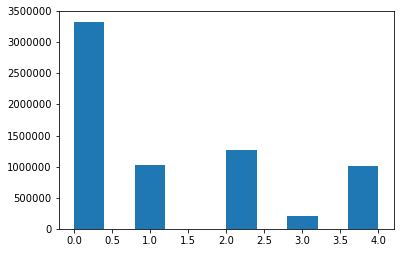

,TrackNumber,Chlorophyll Concentration,Distance,Eastward Water Velocity,Latitude,Longitude,Northward Water Velocity,Oceanic Depth,SOG,Salinity,...,rDTSpeed,rDTSpeed2,rSOG,rSOG2,rSOGmd,rSOGmd2,rSpeed,rSpeed2,sTime,y
0,100047,0.3105,3.186329,0.06,41.101078,1.235355,0.01,NaN,7.4,34.3,...,6.65,6.65,7.40,7.40,7.40,7.40,6.65,6.65,931.0,0
1,100047,0.3043,5.981159,0.06,41.074507,1.221120,0.02,NaN,5.1,34.3,...,8.02,8.02,6.25,6.25,6.25,6.25,7.83,7.83,1290.0,0
2,100047,0.3059,8.779803,0.06,41.043652,1.279553,0.04,NaN,10.2,34.3,...,9.00,9.00,7.57,7.57,7.40,7.40,8.66,8.66,1656.0,0
3,100047,0.3674,3.791024,0.08,40.998602,1.365502,0.07,NaN,10.5,34.3,...,7.98,7.98,8.30,8.30,8.80,8.80,7.80,7.80,1415.0,0
4,100047,0.3405,2.269808,0.12,40.964557,1.438760,0.10,NaN,3.1,34.3,...,7.49,7.49,7.26,7.26,7.40,7.40,7.18,7.18,939.0,0


In [1599]:
trainIndex = buildY(train_list,y_class)
train      = trainAll.set_index('TrackNumber')
train['y'] = trainIndex.set_index('trackfile').y
train      = train.reset_index()
plt.hist(train.y); plt.show(); plt.close()
train.head()

In [1600]:
hTimeMin = 3.0/3600.0
hTimeMax = 48.0

OKtrain = ((train.hTime<=hTimeMax) & (train.hTime>hTimeMin))
NOtrain = np.logical_not(OKtrain)

In [1601]:
import xgboost as xgb

In [1602]:
train_x = train.drop(['y','TrackNumber','Time','Time(seconds)'],axis=1)  #[:1000000]
train_y = train.y.values  #[:1000000]

mtrain = xgb.DMatrix(train_x,label=train_y)

In [1603]:
# Добавляем веса, чтобы не удалять записи из массива
if 0 :
    temp = (0.0+train_x.shape[1]-1.5*trainWeights)/train_x.shape[1]
    mtrain.set_weight(temp)
    trainWeights.min(), trainWeights.max()
    plt.hist(temp,bins=50); plt.show()
    temp.min(),temp.max(), train_x.shape, trainWeights.min(), trainWeights.max()

In [1604]:
train_y.shape, train_x.shape, train_x.columns.tolist(), train_y.max()

((6844359,),
 (6844359, 24),
 ['Chlorophyll Concentration',
  'Distance',
  'Eastward Water Velocity',
  'Latitude',
  'Longitude',
  'Northward Water Velocity',
  'Oceanic Depth',
  'SOG',
  'Salinity',
  'Sea Temperature',
  'Speed',
  'Thermocline Depth',
  'Water Surface Elevation',
  'hTime',
  'oceanic depth',
  'rDTSpeed',
  'rDTSpeed2',
  'rSOG',
  'rSOG2',
  'rSOGmd',
  'rSOGmd2',
  'rSpeed',
  'rSpeed2',
  'sTime'],
 4)

In [1605]:
##import sklearn as sk
##from sklearn.model_selection import cross_val_score

In [1606]:
##cross_val_score(estimator=xgb.XGBClassifier(), X=train_x, y=train_y, cv=5, scoring='accuracy')

In [1607]:
parms = {'reg':'logistic'}
parms = {'multi':'softmax','num_class':5,'metrics':'mlogloss'}
#parms = {'num_class':5,'metrics':'mlogloss'}
parms['objective'] = 'multi:softprob'
parms['eval_metric'] = ['merror','mlogloss']
parms['silent'] = 0

evallist  = [(mtrain,'train')]
##parms = {'reg':'logistic'}
##parms = {'reg':'linear','metrics':'auc'}

##hhcv  = xgb.cv(parms,mtrain,num_boost_round=400,nfold=5,early_stopping_rounds=4,verbose_eval=True,metrics=['merror','mlogloss'])
#hist = xgb.train(parms,mtrain,num_boost_round=30,early_stopping_rounds=5)

In [1610]:
##hhcv

In [1030]:
#xgbmodel = xgb.train(parms,mtrain,num_boost_round=1) # empty nodel

In [1650]:
print datetime.datetime.now()
xgbmodel = xgb.train(parms,mtrain,num_boost_round=300, evals=evallist, xgb_model=xgbmodel) # = 500
print datetime.datetime.now()

2017-09-06 04:33:24.836608
[0]	train-merror:0.02832	train-mlogloss:0.092942
[1]	train-merror:0.028175	train-mlogloss:0.092549
[2]	train-merror:0.028041	train-mlogloss:0.09219
[3]	train-merror:0.027937	train-mlogloss:0.091877
[4]	train-merror:0.027803	train-mlogloss:0.091542
[5]	train-merror:0.02769	train-mlogloss:0.091125
[6]	train-merror:0.027562	train-mlogloss:0.090745
[7]	train-merror:0.027455	train-mlogloss:0.090431
[8]	train-merror:0.027326	train-mlogloss:0.090086
[9]	train-merror:0.027138	train-mlogloss:0.089633
[10]	train-merror:0.027039	train-mlogloss:0.089366
[11]	train-merror:0.02692	train-mlogloss:0.089071
[12]	train-merror:0.02677	train-mlogloss:0.088688
[13]	train-merror:0.026701	train-mlogloss:0.08837
[14]	train-merror:0.02659	train-mlogloss:0.088062
[15]	train-merror:0.026491	train-mlogloss:0.0878
[16]	train-merror:0.026385	train-mlogloss:0.087438
[17]	train-merror:0.026289	train-mlogloss:0.087159
[18]	train-merror:0.026204	train-mlogloss:0.086897
[19]	train-merror:0.026

In [1651]:
#xgbmodel.load_model('../Work/xgbModel.bst')
##xgbmodel.load_model('../Work/xgbModelClean.bst')
##xgbmodel.save_model('../Work/xgbModelCleanSoftProb.bst')
##xgbmodel.save_model('../Work/xgbModel-NotClean-SoftProb-200.bst')
#xgbmodel.save_model('../Work/xgbModel-NotClean-SoftProb-400.bst')
#xgbmodel = xgb.Booster()
#xgbmodel.load_model('../Work/xgbModel-NotClean-SoftProb-400.bst')
xgbmodel.save_model('../Work/xgbModel-NotClean-SoftProb-New3-500.bst')
#xgbmodel.load_model('../Work/xgbModel-NotClean-SoftProb-New2-200.bst')


In [1652]:
pred_y = xgbmodel.predict(mtrain); ##pred_y[-20:],pred_y.max()

In [1653]:
pred_y.shape, pred_y.max() #pred_y[:4]

((6844359, 5), 1.0)

In [1654]:
pred_y_softmax=pred_y.argmax(axis=1); pred_y_softmax.shape

(6844359,)

In [1655]:
((pred_y_softmax==train_y).sum()/float(len(pred_y)))

0.98877951901704741

In [1656]:
df_diff = pd.DataFrame(train.TrackNumber,columns=['TrackNumber'])
df_diff['true_y'] = np.array(train_y,dtype=np.uint8)
df_diff['pred_y'] = np.array(pred_y_softmax, dtype=np.uint8)

df_diff['OK']    = df_diff.true_y==df_diff.pred_y

#print(df_diff.head())

len(df_diff)-df_diff.OK.sum()
aa = df_diff.groupby(['TrackNumber','OK']).size().reset_index(); aa.columns=['TrackNumber','OK','ccount']; aa.head()
bb = pd.DataFrame(train.TrackNumber.unique(),columns=['TrackNumber'])
bb['xx'] = 1.0; bb=bb.set_index(['TrackNumber'])
cc = aa[['TrackNumber','ccount']][aa.OK==True];  cc.head(); cc = cc.set_index(['TrackNumber']); bb['Yes']=cc
cc = aa[['TrackNumber','ccount']][aa.OK==False]; cc.head(); cc = cc.set_index('TrackNumber'); bb['No'] =cc
bb=bb.reset_index().drop('xx',axis=1).fillna(0)
print(bb.head())
float(len(bb[bb.No>bb.Yes]))/len(bb)*100.0

   TrackNumber      Yes    No
0       100047    614.0   0.0
1       100070    350.0  22.0
2       100080   9049.0   1.0
3       100093   5016.0   0.0
4       100144  15159.0   0.0


0.1654259718775848

In [1657]:
#trainAll.describe()

In [1658]:
#testAll.describe()

In [1659]:
fimp  = xgbmodel.get_fscore();
ffimp = [[k,fimp[k]] for k in fimp.keys()]; 
ffimp.sort(key=lambda x: x[1],reverse=True)
tempsum = 0
for temp in ffimp : tempsum+=temp[1];
##print(tempsum)
for ii,temp in enumerate(ffimp) : 
    ffimp[ii][1] = float(ffimp[ii][1])/tempsum*100.0;
ffimp

[['Longitude', 12.219515769931393],
 ['Latitude', 11.042092700256143],
 ['Oceanic Depth', 9.984715136202793],
 ['Eastward Water Velocity', 6.299597289204978],
 ['Water Surface Elevation', 6.006462915011969],
 ['Sea Temperature', 5.727985259528612],
 ['Northward Water Velocity', 5.685410981372009],
 ['Chlorophyll Concentration', 5.181499033354505],
 ['Thermocline Depth', 5.126361853446772],
 ['Salinity', 4.5275302033096265],
 ['rSOGmd2', 4.057119326628466],
 ['rSOG2', 3.8868222140020516],
 ['SOG', 2.913895267275735],
 ['rDTSpeed2', 2.6444908186126366],
 ['rSOGmd', 2.5328205808248243],
 ['rSpeed2', 2.4497658414701386],
 ['hTime', 1.7371701365866596],
 ['rSOG', 1.7176278449737923],
 ['oceanic depth', 1.6562092141904954],
 ['Distance', 1.5263925627621633],
 ['rDTSpeed', 1.2290705546521123],
 ['Speed', 0.9380299974176257],
 ['rSpeed', 0.9094144989844988]]

In [1660]:
y_class, trainIndex[trainIndex.trackfile==100093].typing

(['trawler', 'longliner', 'seiner', 'other', 'support'], 3    other
 Name: typing, dtype: object)

In [1661]:
hTimeMin = 10.0/3600.0
hTimeMax = 48.0

OKtrain = ((train.hTime<=hTimeMax) & (train.hTime>hTimeMin))
NOtrain = np.logical_not(OKtrain)

In [1662]:
if 0 :
    train_o          = train.copy()
    pred_y_o         = pred_y.copy()
    pred_y_softmax_o = pred_y_softmax.copy()
if 0 :
    train            = train_o.copy()
    pred_y           = pred_y_o.copy()
    pred_y_softmax   = pred_y_softmax_o.copy()
len(train), len(pred_y), len(pred_y_softmax), train.shape

(6844359, 6844359, 6844359, (6844359, 28))

In [1663]:
if 0 :
    train          = train[OKtrain]
    pred_y         = pred_y[OKtrain]
    pred_y_softmax = pred_y_softmax[OKtrain]

In [1664]:
len(train), len(pred_y), len(pred_y_softmax)

(6844359, 6844359, 6844359)

    TrackNumber  pred_y        pr
0        100047       0  1.000000
1        100070       1  0.940860
2        100070       2  0.059140
3        100080       2  0.999890
4        100080       4  0.000110
5        100093       3  1.000000
6        100144       0  1.000000
7        100161       1  1.000000
8        100175       0  0.999065
9        100175       1  0.000935
10       100204       0  0.969843
11       100204       1  0.021853
12       100204       2  0.007430
13       100204       3  0.000874
14       100216       3  1.000000
15       100262       0  1.000000
16       100277       2  1.000000
17       100287       0  1.000000
18       100305       0  1.000000
19       100321       0  0.996902


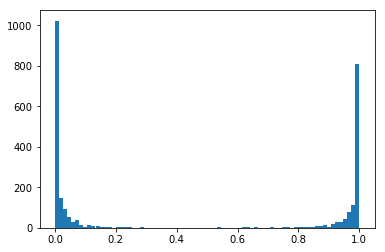

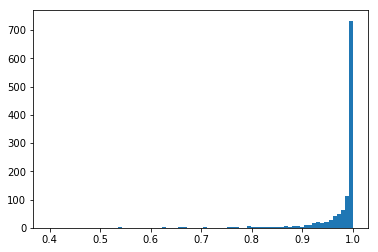

4

In [1665]:
ppred = pd.DataFrame()
ppred['TrackNumber'] = train.TrackNumber
ppred['pred_y']      = pred_y_softmax
ppred['true_y']      = train.y

g0pred = ppred.groupby(['TrackNumber','pred_y']).size()
g1pred = ppred.groupby(ppred.TrackNumber).size(); #print(len(g1pred),g1pred.head())
temp   = np.round(g0pred/g1pred,6)
g0pred = g0pred.reset_index()
g0pred.columns = ['TrackNumber','pred_y','pr']
g0pred['pr'] = temp.values
'''
g0pred = g0pred.set_index(['TrackNumber','pred_y']).unstack(level=-1).fillna(0.0); 
g0pred.columns=[0,1,2,3,4]
print(g0pred.head(20)) #,g0pred.columns)
if 1 :
    for nn in g0pred.columns : g0pred[nn][g0pred[nn]<=0.05] = 0.0;
    temp     = g0pred.sum(axis=1); temp.shape #, g100pred.shape; g100pred,temp.head()
    for nn in g0pred.columns : g0pred[nn] = np.round(g0pred[nn]/temp,6);

temp = g0pred.stack().fillna(0.0)
temp = temp[temp>0.0]
g0pred = temp.reset_index()
g0pred.columns = ['TrackNumber','pred_y','pr']
'''
print(g0pred.head(20))

g2pred = g0pred.reset_index()
g2pred = g2pred.pr.groupby(g2pred.TrackNumber).max()
plt.hist(g0pred.pr,bins=75); plt.show()
plt.hist(g2pred,bins=75); plt.show()
#g0pred
g2pred.head()
len(g2pred[g2pred<0.60])

In [1666]:
#Построение train-решения через probs без времени, только частотность

g100     = pd.DataFrame(pred_y); g100.head(), g100.columns
g100pred = g100.groupby(ppred.TrackNumber).sum(); g100pred.head()
temp     = g100pred.sum(axis=1); temp.shape #, g100pred.shape; g100pred,temp.head()
for nn in g100pred.columns : g100pred[nn] = np.round(g100pred[nn]/temp,6); 
g100pred.head()
if 1 :
    for nn in g100pred.columns : g100pred[nn][g100pred[nn]<=0.05] = 0.0;
    temp     = g100pred.sum(axis=1); temp.shape #, g100pred.shape; g100pred,temp.head()
    for nn in g100pred.columns : g100pred[nn] = np.round(g100pred[nn]/temp,6);

temp = g100pred.stack()
temp = temp[temp>0.0]
g100pred = pd.DataFrame(temp.reset_index());
g100pred.columns=['TrackNumber','pred_y','pr']
del temp
g100pred.head(30), g100pred.pred_y.dtype

(    TrackNumber  pred_y        pr
 0        100047       0  1.000000
 1        100070       1  0.844250
 2        100070       2  0.155750
 3        100080       2  1.000000
 4        100093       3  1.000000
 5        100144       0  1.000000
 6        100161       1  1.000000
 7        100175       0  1.000000
 8        100204       0  0.948502
 9        100204       1  0.051498
 10       100216       3  1.000000
 11       100262       0  1.000000
 12       100277       2  1.000000
 13       100287       0  1.000000
 14       100305       0  1.000000
 15       100321       0  1.000000
 16       100362       1  0.704347
 17       100362       2  0.295653
 18       100370       0  1.000000
 19       100380       2  1.000000
 20       100383       2  1.000000
 21       100403       0  1.000000
 22       100448       4  1.000000
 23       100453       1  1.000000
 24       100457       0  1.000000
 25       100464       2  1.000000
 26       100481       0  1.000000
 27       100488    

In [1668]:
g110     = pd.DataFrame(pred_y) # в работе время 
for nn in g110.columns : g110[nn] = np.round(g110[nn]*0.5*(train.sTime+train.sTime.shift().fillna(0.0)),6);
    
g110pred = g110.groupby(ppred.TrackNumber).sum(); g110pred.head()
temp     = g110pred.sum(axis=1); temp.shape #, g110pred.shape; g110pred,temp.head()
for nn in g110pred.columns : g110pred[nn] = np.round(g110pred[nn]/temp,6);
if 1 :
    for nn in g110pred.columns : g110pred[nn][g110pred[nn]<=0.05] = 0.0;
    temp     = g110pred.sum(axis=1); temp.shape #, g110pred.shape; g110pred,temp.head()
    for nn in g110pred.columns : g110pred[nn] = np.round(g110pred[nn]/temp,6);

g110pred.head(15)

temp = g110pred.stack()
temp = temp[temp>0.0]
g110pred = pd.DataFrame(temp.reset_index());
g110pred.columns=['TrackNumber','pred_y','pr']
del temp
g110pred.head(20), g110pred.pred_y.dtype, g110pred.pr.max()

(    TrackNumber  pred_y        pr
 0        100047       0  1.000000
 1        100070       1  0.796992
 2        100070       2  0.203008
 3        100080       2  1.000000
 4        100093       3  1.000000
 5        100144       0  1.000000
 6        100161       1  1.000000
 7        100175       0  1.000000
 8        100204       0  0.891488
 9        100204       1  0.108512
 10       100216       3  1.000000
 11       100262       0  1.000000
 12       100277       2  1.000000
 13       100287       0  1.000000
 14       100305       0  1.000000
 15       100321       0  0.881807
 16       100321       1  0.058639
 17       100321       3  0.059553
 18       100362       1  0.887580
 19       100362       2  0.112420, dtype('int64'), 1.0)

In [1669]:
ggtrain = pd.DataFrame(train[['TrackNumber','y']].groupby(['TrackNumber','y']).size().reset_index()); ggtrain.head()
ggtrain.columns   = ['TrackNumber','pred_y','size']
ggtrain['true_y'] = 1.0
ggtrain.head()

,TrackNumber,pred_y,size,true_y
0,100047,0,614,1.0
1,100070,1,372,1.0
2,100080,2,9050,1.0
3,100093,3,5016,1.0
4,100144,0,15159,1.0


In [1670]:
#ggtrain  = ggtrain.reset_index()
#g100pred = g100pred.reset_index()
#gg.reset_index()

In [1671]:
#ggtrain  = ggtrain.set_index(['TrackNumber','pred_y'])
#g100pred = g100pred.set_index(['TrackNumber','pred_y']) 
gg = pd.merge(g0pred.reset_index(),ggtrain,how='outer',suffixes=('_x','_y'),on=('TrackNumber','pred_y'))
gg = gg.drop('size',axis=1).fillna(0.0)
print(gg.tail(15))
ggBad = gg[(gg.pr!=gg.true_y) & (gg.pr<0.50) & (gg.true_y>0.50)]['TrackNumber'].unique(); ggBad
##gg.set_index('TrackNumber')
ggBadTracks = gg.set_index('TrackNumber').loc[ggBad.tolist(),:].reset_index().TrackNumber.unique()
print len(ggBadTracks), ggBadTracks.tolist()
##gg.reset_index()
#ggtrain.pred_y.dtype
#g100pred.pred_y.dtype

       index  TrackNumber  pred_y        pr  true_y
2666  2666.0       132557       4  0.993805     1.0
2667  2667.0       132588       0  0.984065     1.0
2668  2668.0       132588       1  0.015504     0.0
2669  2669.0       132588       2  0.000431     0.0
2670  2670.0       132642       1  0.000980     0.0
2671  2671.0       132642       2  0.000713     0.0
2672  2672.0       132642       4  0.998307     1.0
2673  2673.0       132644       1  0.001157     0.0
2674  2674.0       132644       2  0.994764     1.0
2675  2675.0       132644       4  0.004079     0.0
2676  2676.0       132653       0  0.999169     1.0
2677  2677.0       132653       2  0.000831     0.0
2678  2678.0       132759       2  0.994944     1.0
2679  2679.0       132759       4  0.005056     0.0
2680     0.0       124127       0  0.000000     1.0
2 [123632, 124127]


In [1672]:
gg.head()
gg.set_index('TrackNumber').loc[124127,:]
#ggBad.tolist()
train[train.TrackNumber==124127].iloc[:,:] #range(7)+[9,10,11,12,13,14,16,17,18,19,20]]
#train[train.TrackNumber==131933].iloc[:,range(4)+[5,8,9,11,12,13,14,16,17,18,19,20]]

,TrackNumber,Chlorophyll Concentration,Distance,Eastward Water Velocity,Latitude,Longitude,Northward Water Velocity,Oceanic Depth,SOG,Salinity,...,rDTSpeed,rDTSpeed2,rSOG,rSOG2,rSOGmd,rSOGmd2,rSpeed,rSpeed2,sTime,y
5017163,124127,-99999.0,0.002271,0.09,43.658698,-7.352898,0.33,-6.0,0.0,34.4,...,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,904.0,0
5017164,124127,-99999.0,0.003463,0.09,43.658692,-7.352925,0.33,-6.0,0.0,34.4,...,0.01,0.01,0.0,0.0,0.0,0.0,0.00,0.00,1009.0,0
5017165,124127,-99999.0,0.279200,0.09,43.658672,-7.352958,0.33,-6.0,0.0,34.4,...,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,2098799.0,0
5017166,124127,-99999.0,0.004969,0.30,43.657407,-7.349960,-0.06,-6.0,0.0,34.3,...,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,948.0,0
5017167,124127,-99999.0,0.005168,0.30,43.657378,-7.350007,-0.06,-6.0,0.0,34.3,...,0.00,0.00,0.0,0.0,0.0,0.0,0.01,0.01,941.0,0
5017168,124127,-99999.0,0.005193,0.30,43.657382,-7.349943,-0.06,-6.0,0.0,34.3,...,0.00,0.00,0.0,0.0,0.0,0.0,0.01,0.01,950.0,0
5017169,124127,-99999.0,0.002563,0.30,43.657395,-7.350005,-0.06,-6.0,0.0,34.3,...,0.00,0.00,0.0,0.0,0.0,0.0,0.01,0.01,941.0,0
5017170,124127,-99999.0,0.000000,0.30,43.657418,-7.350007,-0.06,-6.0,0.0,34.3,...,0.01,0.00,0.0,0.0,0.0,0.0,0.01,0.01,0.0,0


In [1673]:
tr000 = g0pred.copy()
tr100 = g100pred.copy()
tr110 = g110pred.copy()

In [1674]:
# Готовим решение по test

In [1635]:
print datetime.datetime.now()
testAll_ = buildX(test_list['trackfile'].values.tolist(), hTimeMin=2.0/(60.0*60.0));
temp      = '\tLatitudes: between {} and {} \n\tLongitudes: between {} and {} \n\tFiles={} Shapes={}'
print(temp.format(testAll_.Latitude.min(), testAll_.Latitude.max(), testAll_.Longitude.min(), 
                  testAll_.Longitude.max(), len(testAll_.TrackNumber.unique()),  testAll_.shape))
testAll  = testAll_
testAll.to_csv('../Data/testingAllNew3.csv',index=False)
del testAll_
print datetime.datetime.now()

2017-09-06 03:56:26.557605


/home/boba/anaconda2/envs/tensorflow-gpu/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


	Latitudes: between -71.80556 and 78.698025 
	Longitudes: between -179.999995 and 179.999983 
	Files=1211 Shapes=(5663924, 27)
2017-09-06 04:11:23.209639


In [1060]:
#testAll.to_csv('../Data/testingAll.csv',index=False)

In [1636]:
testAll = pd.read_csv('../Data/testingAllNew3.csv')

In [1637]:
#testWeights = dataClean(testAll)

In [1675]:
!ls -la ../Result
!ls -la ../Data
!ls -la ../Work
testAll.shape

total 197
drwxrwxrwx 1 boba boba   4096 сен  6 04:21 .
drwxrwxrwx 1 boba boba   4096 сен  1 16:12 ..
drwxrwxrwx 1 boba boba   4096 сен  6 04:21 Best
-rwxrwxrwx 1 boba boba 185082 сен  6 04:16 bobaFish.csv
-rwxrwxrwx 1 boba boba    413 сен  1 16:53 FishingForFishermen2.java
drwxrwxrwx 1 boba boba      0 сен  1 16:36 .ipynb_checkpoints
total 6229516
drwxrwxrwx 1 boba boba       4096 сен  6 04:10 .
drwxrwxrwx 1 boba boba       4096 сен  1 16:12 ..
drwxrwxrwx 1 boba boba          0 сен  6 04:08 .ipynb_checkpoints
-rwxrwxrwx 1 boba boba  973453918 сен  2 02:54 testingAll.csv
-rwxrwxrwx 1 boba boba  968177089 сен  6 04:11 testingAllNew3.csv
-rwxrwxrwx 1 boba boba  933116782 сен  5 03:33 testingAllNew.csv
-rwxrwxrwx 1 boba boba       8477 авг 25 23:42 testing.txt
-rwxrwxrwx 1 boba boba 1195264916 сен  2 01:53 trainingAll.csv
-rwxrwxrwx 1 boba boba 1173202846 сен  6 03:14 trainingAllNew3.csv
-rwxrwxrwx 1 boba boba 1135229204 сен  5 02:37 trainingAllNew.csv
-rwxrwxrwx 1 boba boba      18151 авг

(5663924, 27)

In [1676]:
test_x = testAll.drop(['TrackNumber','Time','Time(seconds)'],axis=1)  #[:1000000]
mtest  = xgb.DMatrix(test_x)
test_x.shape

(5663924, 24)

In [1677]:
test_y = xgbmodel.predict(mtest); ##pred_y[-20:],pred_y.max()

In [1678]:
test_y_softmax = test_y.argmax(axis=1); test_y_softmax.shape

(5663924,)

In [1679]:
test = testAll

In [1680]:
if 0 :
    test_o           = test.copy()
    test_y_o         = test_y.copy()
    test_y_softmax_o = test_y_softmax.copy()
if 0 :
    test             = test_o.copy()
    test_y           = test_y_o.copy()
    test_y_softmax   = test_y_softmax_o.copy()
len(test), len(test_y), len(test_y_softmax)

(5663924, 5663924, 5663924)

In [1681]:
if 0 :
    test           = test[OKtest]
    test_y         = test_y[OKtest]
    test_y_softmax = test_y_softmax[OKtest]
len(test), len(test_y), len(test_y_softmax)

(5663924, 5663924, 5663924)

('Common result \n',     TrackNumber  pred_y      pr
0        100015       0  0.0328
1        100015       1  0.8794
2        100015       2  0.0813
3        100015       3  0.0066
4        100045       0  1.0000
5        100060       0  0.0469
6        100060       1  0.7380
7        100060       2  0.2151
8        100112       0  1.0000
9        100131       0  0.9364
10       100131       1  0.0019
11       100131       3  0.0617
12       100150       1  0.9315
13       100150       2  0.0505
14       100150       3  0.0005
15       100150       4  0.0175
16       100151       0  0.0899
17       100151       1  0.0026
18       100151       2  0.0378
19       100151       4  0.8697
20       100215       0  0.4375
21       100215       1  0.3125
22       100215       2  0.2500
23       100221       0  1.0000
24       100227       0  1.0000)


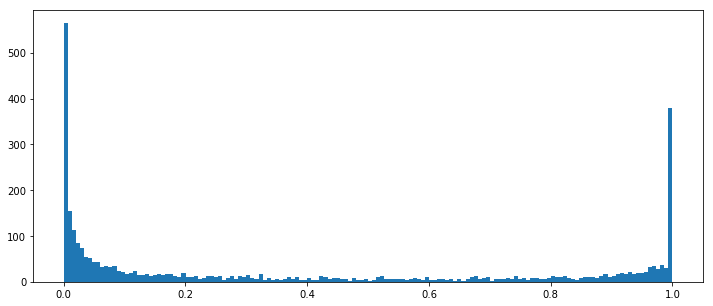

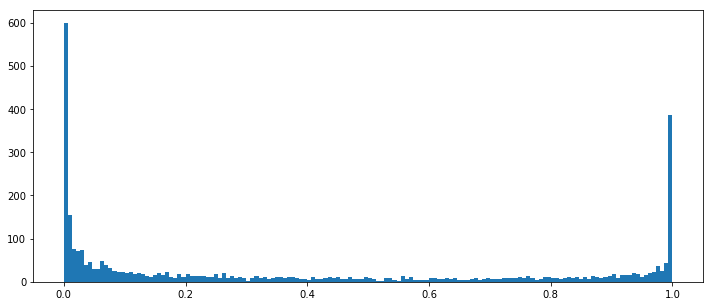

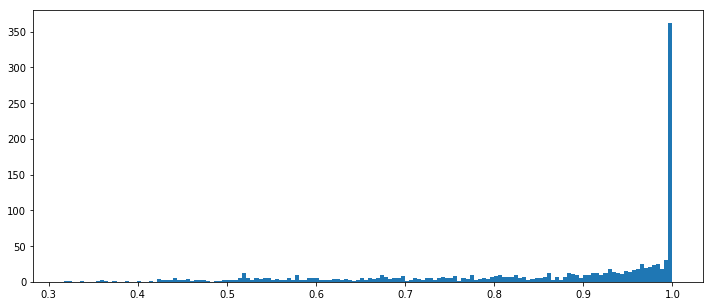

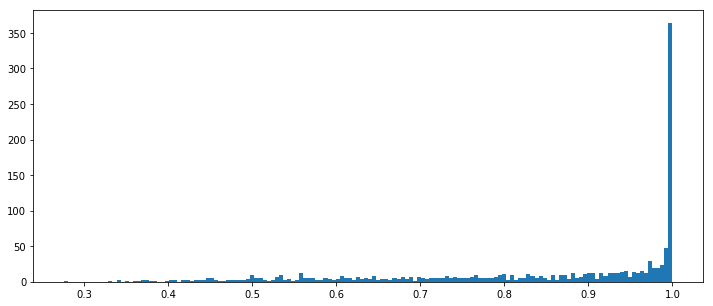

161 0.0 1.0 0.0 1.0 5e-06 1.0


In [1682]:
# Распределение результата test
ppred = pd.DataFrame()
ppred['TrackNumber'] = test.TrackNumber
ppred['pred_y'] = np.array(test_y_softmax,dtype=np.uint8)
##print(ppred.head())

tySize = ppred.groupby(['TrackNumber','pred_y']).size();
tSize  = ppred.groupby(['TrackNumber']).size();

g0pred = pd.DataFrame(np.round(tySize/tSize,4)).reset_index()   # common result table [Track#, pred#, prob]
g0pred.columns=['TrackNumber','pred_y','pr']

'''
g0pred = g0pred.set_index(['TrackNumber','pred_y']).unstack(level=-1).fillna(0.0); 
g0pred.columns=[0,1,2,3,4]
##print(g0pred.head(20)) #,g0pred.columns)
if 1 :
    for nn in g0pred.columns : g0pred[nn][g0pred[nn]<=0.05] = 0.0;
    temp     = g0pred.sum(axis=1); temp.shape #, g100pred.shape; g100pred,temp.head()
    for nn in g0pred.columns : g0pred[nn] = np.round(g0pred[nn]/temp,6);

temp = g0pred.stack().fillna(0.0)
temp = temp[temp>0.0]
g0pred = temp.reset_index()
g0pred.columns = ['TrackNumber','pred_y','pr']
'''
print('Common result \n',g0pred.head(25))

ggmax, g4pred = [], g0pred.groupby('TrackNumber')

for tt in g0pred.TrackNumber.unique().tolist() :
    aa = g4pred.get_group(tt)
    ggmax.append(aa.pred_y[aa.pr.argmax()])

##print(len(ggmax),ggmax[:40])

g1pred = pd.DataFrame(g0pred.TrackNumber.unique())   # table only one max result for Track# [Track#, pred#, prob]
g1pred['pred_y'] = np.array(ggmax)
g1pred['pr']     = 1.0
g1pred.columns=['TrackNumber','pred_y','pr']

##print 'Only result pred = 1.0 \n',g1pred.head()

g2pred = ppred.copy()
g2pred['sTime']  = testAll.sTime
g2pred['sTimeX'] = testAll.sTime.shift()
g2pred = g2pred.fillna(0)

g2pred = g2pred.groupby(['TrackNumber','pred_y']).sum();
g2pred['ssTime'] = (g2pred.sTime+g2pred.sTimeX)*0.5
ttSize = g2pred.reset_index().groupby(['TrackNumber']).sum();
g2pred['prS']  = np.round(g2pred.sTime/ttSize.sTime,6)
g2pred['prX']  = np.round(g2pred.sTimeX/ttSize.sTimeX,6)
g2pred['prSX'] = np.round(g2pred.ssTime/ttSize.ssTime,6)
g2pred['pr']   = g2pred.prSX

##print g2pred.head(20)

g3pred = g0pred.pr.groupby(g0pred.TrackNumber).max()            # max pr for each Track#
g3pred = g2pred.reset_index().prSX.groupby(g2pred.reset_index().TrackNumber).max()            # max pr for each Track#

plt.figure(figsize=(12,5)); plt.hist(g0pred.pr,bins=150); plt.show()
plt.figure(figsize=(12,5)); plt.hist(g2pred.prSX,bins=150); plt.show()

g3pred = g0pred.pr.groupby(g0pred.TrackNumber).max()            # max pr for each Track#
plt.figure(figsize=(12,5)); plt.hist(g3pred,bins=150); plt.show()
g3pred = g2pred.reset_index().prSX.groupby(g2pred.reset_index().TrackNumber).max()            # max pr for each Track#
plt.figure(figsize=(12,5)); plt.hist(g3pred,bins=150); plt.show()

print len(g3pred[g3pred<0.60]), g2pred.prS.min(), g2pred.prS.max(), g2pred.prX.min(), g2pred.prX.max(), g2pred.prSX.min(), g2pred.prSX.max()

In [1683]:
#Построение решение через probs

g100     = pd.DataFrame(test_y); g100.head(), g100.columns
g100pred = g100.groupby(ppred.TrackNumber).sum(); g100pred.head()
temp     = g100pred.sum(axis=1); temp.shape #, g100pred.shape; g100pred,temp.head()
for nn in g100pred.columns : g100pred[nn] = np.round(g100pred[nn]/temp,6);
if 0 :
    for nn in g100pred.columns : g100pred[nn][g100pred[nn]<=0.05] = 0.0;
    temp     = g100pred.sum(axis=1); temp.shape #, g100pred.shape; g100pred,temp.head()
    for nn in g100pred.columns : g100pred[nn] = np.round(g100pred[nn]/temp,6);

g100pred.head(15)

temp = g100pred.stack()
temp = temp[temp>0.0]
g100pred = pd.DataFrame(temp.reset_index());
g100pred.columns=['TrackNumber','pred_y','pr']
del temp
g100pred.head(20), g100pred.pred_y.dtype

(    TrackNumber  pred_y        pr
 0        100015       0  0.045899
 1        100015       1  0.807082
 2        100015       2  0.130116
 3        100015       3  0.015002
 4        100015       4  0.001901
 5        100045       0  0.999888
 6        100045       2  0.000090
 7        100045       4  0.000022
 8        100060       0  0.065142
 9        100060       1  0.647603
 10       100060       2  0.286972
 11       100060       3  0.000019
 12       100060       4  0.000265
 13       100112       0  0.991838
 14       100112       1  0.000170
 15       100112       2  0.000009
 16       100112       3  0.007854
 17       100112       4  0.000129
 18       100131       0  0.823598
 19       100131       1  0.002545, dtype('int64'))

In [1684]:
g110     = pd.DataFrame(test_y)
for nn in g110.columns : g110[nn] = np.round(g110[nn]*0.5*(testAll.sTime+testAll.sTime.shift().fillna(0.0)),6);
    
g110pred = g110.groupby(ppred.TrackNumber).sum(); g110pred.head()
temp     = g110pred.sum(axis=1); temp.shape #, g110pred.shape; g110pred,temp.head()
for nn in g110pred.columns : g110pred[nn] = np.round(g110pred[nn]/temp,6);
if 0 :
    for nn in g110pred.columns : g110pred[nn][g110pred[nn]<=0.05] = 0.0;
    temp     = g110pred.sum(axis=1); temp.shape #, g110pred.shape; g110pred,temp.head()
    for nn in g110pred.columns : g110pred[nn] = np.round(g110pred[nn]/temp,6);

g110pred.head(15)

temp = g110pred.stack()
temp = temp[temp>0.0]
g110pred = pd.DataFrame(temp.reset_index());
g110pred.columns=['TrackNumber','pred_y','pr']
del temp
g110pred.head(20), g110pred.pred_y.dtype

(    TrackNumber  pred_y        pr
 0        100015       0  0.190394
 1        100015       1  0.703588
 2        100015       2  0.086150
 3        100015       3  0.015730
 4        100015       4  0.004137
 5        100045       0  0.999880
 6        100045       2  0.000100
 7        100045       4  0.000019
 8        100060       0  0.111562
 9        100060       1  0.804240
 10       100060       2  0.084061
 11       100060       3  0.000010
 12       100060       4  0.000127
 13       100112       0  0.989347
 14       100112       1  0.000479
 15       100112       2  0.000008
 16       100112       3  0.009974
 17       100112       4  0.000191
 18       100131       0  0.801817
 19       100131       1  0.030011, dtype('int64'))

In [1685]:
te000 = g0pred.copy()
te100 = g100pred.copy()
te110 = g110pred.copy()

In [1687]:
#
# Построение решения из softProbs взвешенное временем до-после точки --> 874xxx
#  2 подход: -очистка, 200 раундов, отсутствие весов --> 880536.69
#  3 подход: --------  400 раундов --> 878101.38
#  4 подход: без взвешивания по времени, только среднее по точкам, 400 раундов --> 886230.54
#  5 подход: только softmax + выброс плохих точек, 400 раундов --> 885310.33
#  6 подход rolling с мелкими зачистками данных, 200 раундов --> 887014.0  2017-09-04
#  7 подход rolling с мелкими зачистками данных, 400 раундов --> 840060.63 2017-09-04
#  8 подход == 7, проверка подсчета - выключил 5% - подсчет max().sum().norm() g0pred      --> 887517.77  
#  9 подход == 7, проверка подсчета - выключил 5% - подсчет sum().max().norm() g100pred    --> 910811.59
# 10 подход == 7, проверка подсчета - выключил 5% - подсчет sum(pr*htime).max().norm() g110pred    --> 899865.96
# 11 подход подравлена загрузка, улучшен rolling - подсчет sum().max().norm() g100pred    --> 917339.22
# 12 подход == 12, 400 rounds  --> 919742.90 2017-09-05
# 13 подход == уточнена очистка данных, добавлены доп rollings, 200 rounds, g100pred  --> 918466.43 2017-09-06
# 14 подход == уточнена очистка данных, добавлены доп rollings, 500 rounds, g100pred  --> 919787.85	 2017-09-06
# 15 подход == 14, 500 rounds, g0pred  --> 902710.52 2017-09-06
#
#
test_r = g110pred.copy()
test_r = g100pred.copy() # 4-6 step
test_r = g0pred.copy()   # 5-8 step
test_r = g100pred.copy() #  9 step
test_r = g110pred.copy() # 10 step
test_r = g100pred.copy() # 11-14 step
test_r = g0pred.copy()   # 15 step

##print(test_r.pred_y.values.tolist())
test_r['FishingType'] = np.array([y_class[x] for x in test_r.pred_y.values.tolist()])
print(test_r[['TrackNumber','FishingType','pr']].head(25))
test_r[['TrackNumber','FishingType','pr']].to_csv('../Result/bobaFish.csv',index=False,header=False)

    TrackNumber FishingType      pr
0        100015     trawler  0.0328
1        100015   longliner  0.8794
2        100015      seiner  0.0813
3        100015       other  0.0066
4        100045     trawler  1.0000
5        100060     trawler  0.0469
6        100060   longliner  0.7380
7        100060      seiner  0.2151
8        100112     trawler  1.0000
9        100131     trawler  0.9364
10       100131   longliner  0.0019
11       100131       other  0.0617
12       100150   longliner  0.9315
13       100150      seiner  0.0505
14       100150       other  0.0005
15       100150     support  0.0175
16       100151     trawler  0.0899
17       100151   longliner  0.0026
18       100151      seiner  0.0378
19       100151     support  0.8697
20       100215     trawler  0.4375
21       100215   longliner  0.3125
22       100215      seiner  0.2500
23       100221     trawler  1.0000
24       100227     trawler  1.0000


In [84]:
g0pred.head()
test_r = g0pred.copy()
##print(test_r.pred_y.values.tolist())
test_r['FishingType'] = np.array([y_class[x] for x in test_r.pred_y.values.tolist()])
print(test_r[['TrackNumber','FishingType','pr']].head(15))
test_r[['TrackNumber','FishingType','pr']].to_csv('../Result/bobaFish.csv',index=False,header=False)

    TrackNumber FishingType      pr
0        100015     trawler  0.0376
1        100015   longliner  0.8243
2        100015      seiner  0.1368
3        100015       other  0.0013
4        100045     trawler  1.0000
5        100060     trawler  0.0532
6        100060   longliner  0.7423
7        100060      seiner  0.2039
8        100060     support  0.0005
9        100112     trawler  1.0000
10       100131     trawler  0.8094
11       100131   longliner  0.0029
12       100131       other  0.1877
13       100150   longliner  0.9298
14       100150      seiner  0.0642


In [112]:
#
#  2017-09-02 Взвешенная по времени нахождения около точки (+-) вероятности типов судов
#  2017-09-02 +- хуже 886xxx -> 870xxx
#
g2pred.head()
test_r = g2pred.reset_index().copy()
test_r['pr'] = test_r.prSX
##print(test_r.pred_y.values.tolist())
test_r['FishingType'] = np.array([y_class[x] for x in test_r.pred_y.values.tolist()])
print(test_r[['TrackNumber','FishingType','pr']].head(25))
test_r[['TrackNumber','FishingType','pr']].to_csv('../Result/bobaFish.csv',index=False,header=False)

    TrackNumber FishingType        pr
0        100015     trawler  0.123381
1        100015   longliner  0.796768
2        100015      seiner  0.068208
3        100015       other  0.011644
4        100045     trawler  1.000000
5        100060     trawler  0.111688
6        100060   longliner  0.816666
7        100060      seiner  0.071583
8        100060     support  0.000063
9        100112     trawler  1.000000
10       100131     trawler  0.798129
11       100131   longliner  0.047469
12       100131       other  0.154402
13       100150   longliner  0.917904
14       100150      seiner  0.074431
15       100150     support  0.007665
16       100151     trawler  0.371117
17       100151   longliner  0.012507
18       100151      seiner  0.019218
19       100151     support  0.597159
20       100215     trawler  0.026426
21       100215   longliner  0.025318
22       100215      seiner  0.948256
23       100221     trawler  1.000000
24       100227     trawler  0.999765


In [113]:
#
#  2017-09-02 Взвешенная по времени нахождения около точки (- предыдущее время) вероятности типов судов
#  2017-09-02 - 870xxx->863xxx
#
g2pred.head()
test_r = g2pred.reset_index().copy()
test_r['pr'] = test_r.prX
##print(test_r.pred_y.values.tolist())
test_r['FishingType'] = np.array([y_class[x] for x in test_r.pred_y.values.tolist()])
print(test_r[['TrackNumber','FishingType','pr']].head(25))
test_r[['TrackNumber','FishingType','pr']].to_csv('../Result/bobaFish.csv',index=False,header=False)

    TrackNumber FishingType        pr
0        100015     trawler  0.101394
1        100015   longliner  0.837527
2        100015      seiner  0.051816
3        100015       other  0.009262
4        100045     trawler  1.000000
5        100060     trawler  0.092662
6        100060   longliner  0.848095
7        100060      seiner  0.059195
8        100060     support  0.000048
9        100112     trawler  1.000000
10       100131     trawler  0.798759
11       100131   longliner  0.047166
12       100131       other  0.154074
13       100150   longliner  0.917502
14       100150      seiner  0.075145
15       100150     support  0.007353
16       100151     trawler  0.370181
17       100151   longliner  0.014386
18       100151      seiner  0.019686
19       100151     support  0.595747
20       100215     trawler  0.048802
21       100215   longliner  0.002205
22       100215      seiner  0.948993
23       100221     trawler  1.000000
24       100227     trawler  0.999768


In [373]:
#  2017-09-01 Почему-то дает провал на 511650.89 с 890501, хотя не должна?
# Only max predictions pr<-1.0
g1pred.head()
test_r = g1pred.copy()
##print(test_r.pred_y.values.tolist())
test_r['FishingType'] = np.array([y_class[x] for x in test_r.pred_y.values.tolist()])
print(test_r[['TrackNumber','FishingType','pr']].head())
##test_r[['TrackNumber','FishingType','pr']].to_csv('../Result/bobaFish.csv',index=False,header=False)

   TrackNumber FishingType   pr
0       100015   longliner  1.0
1       100045     trawler  1.0
2       100060   longliner  1.0
3       100112     trawler  1.0
4       100131     trawler  1.0


In [42]:
##test_yy = xgbmodel.predict(mtest, pred_contribs=True)
xgb.__version__

'0.6'

In [273]:
xgbmodel.attributes()

{}

In [82]:
bbins = [aa for aa in range(49)] + [max(trainAll.hTime.max(),trainAll.hTime.max(),)+1.0]

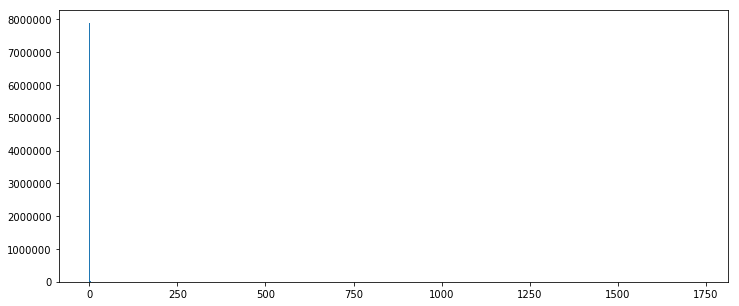

In [87]:
plt.figure(figsize=(12,5)); hh, bb, _ = plt.hist(trainAll.hTime,bins=bbins); plt.show()

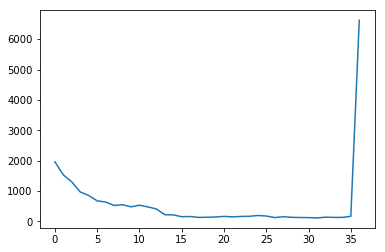

(50, 10596.0, array([  6.41767600e+06,   7.81920000e+04,   1.72610000e+04,
          1.02150000e+04,   7.46600000e+03,   6.46400000e+03,
          6.23000000e+03,   7.07300000e+03,   6.33900000e+03,
          4.01400000e+03,   2.76100000e+03,   2.11200000e+03,
          1.96100000e+03,   1.53100000e+03,   1.30000000e+03,
          9.69000000e+02,   8.53000000e+02,   6.78000000e+02,
          6.38000000e+02,   5.25000000e+02,   5.50000000e+02,
          4.81000000e+02,   5.35000000e+02,   4.78000000e+02,
          4.11000000e+02,   2.22000000e+02,   2.16000000e+02,
          1.55000000e+02,   1.63000000e+02,   1.33000000e+02,
          1.38000000e+02,   1.46000000e+02,   1.66000000e+02,
          1.51000000e+02,   1.64000000e+02,   1.69000000e+02,
          1.96000000e+02,   1.78000000e+02,   1.28000000e+02,
          1.56000000e+02,   1.35000000e+02,   1.30000000e+02,
          1.26000000e+02,   1.16000000e+02,   1.40000000e+02,
          1.33000000e+02,   1.33000000e+02,   1.69000000e

In [96]:
plt.plot(hh[12:]); plt.show()
len(bb), hh[24:].sum(), hh, bb

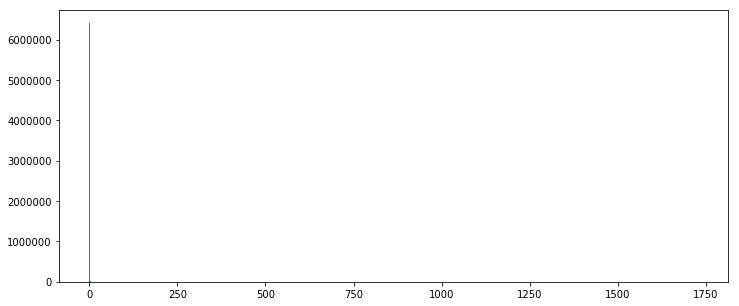

In [95]:
plt.figure(figsize=(12,5)); hh, bb, _ = plt.hist(testAll.hTime,bins=bbins); plt.show()

In [369]:
hTimeMin = 3.0/3600.0
hTimeMax = 48.0

hTimeMin = 10.0/3600.0
hTimeMax = 48.0

OKtrain = ((trainAll.hTime<=hTimeMax) & (trainAll.hTime>hTimeMin))
NOtrain = np.logical_not(OKtrain)
OKtest  = ((testAll.hTime<=hTimeMax) & (testAll.hTime>hTimeMin))
NOtest  = np.logical_not(OKtest)


print('All tracks: \ttrain={}, test={}\nTracks with wrong records:  \ttrain={}, test={}\nTracks with good records:  \ttrain={}, test={}'. \
          format(len(trainAll.TrackNumber.unique()),len(testAll.TrackNumber.unique()), \
                 len(trainAll.TrackNumber[NOtrain].unique()), \
                 len(testAll.TrackNumber[NOtest].unique()), \
                 len(trainAll.TrackNumber[OKtrain].unique()), \
                 len(testAll.TrackNumber[OKtest].unique())))

All tracks: 	train=1209, test=1211
Tracks with wrong records:  	train=1209, test=1211
Tracks with good records:  	train=1209, test=1211


In [157]:
print('train={}, test={}'.format(len(trainAll.TrackNumber[((trainAll.hTime>hTimeMax) | (trainAll.hTime<hTimeMin))]),
                                 len(testAll.TrackNumber[((testAll.hTime>hTimeMax) | (testAll.hTime<hTimeMin))] ) ))

train=938990, test=658466


In [133]:
train[train.hTime> 48.0]

,TrackNumber,Chlorophyll Concentration,Depth,Distance,Eastward Water Velocity,Latitude,Longitude,Northward Water Velocity,Oceanic Depth,SOG,...,Sea Temperature,Speed,Thermocline Depth,Time,Time(seconds),Water Surface Elevation,hTime,oceanic depth,sTime,y
69,100047,0.3114,-4,0.635781,-0.04,41.099857,1.232748,-0.03,NaN,8.9,...,10.6,0.005562,113.6,210835,210835,-0.21,61.726111,-4.0,222214.0,0
93,100047,0.3095,-5,0.905187,-0.21,41.107890,1.238818,-0.10,NaN,0.0,...,10.2,0.004476,123.8,643825,643825,-0.19,109.190278,-5.0,393085.0,0
179,100047,0.3043,-10,3.923416,-0.04,41.078055,1.213548,0.01,NaN,10.6,...,9.9,0.034441,263.1,1420301,1420301,-0.17,61.510556,-10.0,221438.0,0
251,100047,0.3043,-10,2.912001,0.10,41.082810,1.215468,0.04,NaN,10.7,...,9.8,0.025526,323.8,2024705,2024705,-0.21,61.597778,-10.0,221752.0,0
297,100047,0.3092,-5,3.436802,0.05,41.104813,1.239307,0.11,NaN,0.5,...,9.6,0.029979,157.6,2629425,2629425,-0.29,61.900000,-5.0,222840.0,0
359,100047,0.2080,-4,2.703458,-0.06,41.088820,1.221198,0.05,NaN,9.4,...,9.6,0.023528,252.4,3232398,3232398,-0.30,62.043333,-4.0,223356.0,0
418,100047,0.2047,-5,0.207280,-0.12,41.108707,1.240357,0.29,NaN,0.0,...,9.6,0.001338,380.1,3759683,3759683,-0.23,83.626111,-5.0,301054.0,0
453,100047,0.2042,-5,2.327180,-0.12,41.104318,1.241150,0.17,NaN,0.8,...,9.7,0.020191,184.3,4442169,4442169,-0.24,62.235278,-5.0,224047.0,0
473,100047,0.2092,-3,0.086283,0.00,41.083383,1.215767,0.10,NaN,7.3,...,9.9,0.000745,252.4,5046051,5046051,-0.25,62.506389,-3.0,225023.0,0
495,100047,0.1735,-5,3.308095,-0.02,41.105027,1.242002,0.18,NaN,8.4,...,9.8,0.028623,229.6,5651446,5651446,-0.26,62.406389,-5.0,224663.0,0


In [714]:
# Смотрим статистику по судам

True : [569.0, 193.0, 266.0, 53.0, 128.0] 

Train: [572.837, 189.484, 266.883, 49.756, 130.041]
Train: [575.115, 187.272, 265.228, 48.658, 132.727]
Train: [574.706, 185.916, 264.168, 48.01, 136.201]

Test : [584.974, 194.675, 274.295, 33.745, 123.313]
Test : [576.366, 196.283, 274.782, 36.338, 127.231]
Test : [574.318, 201.913, 272.546, 37.461, 124.761]


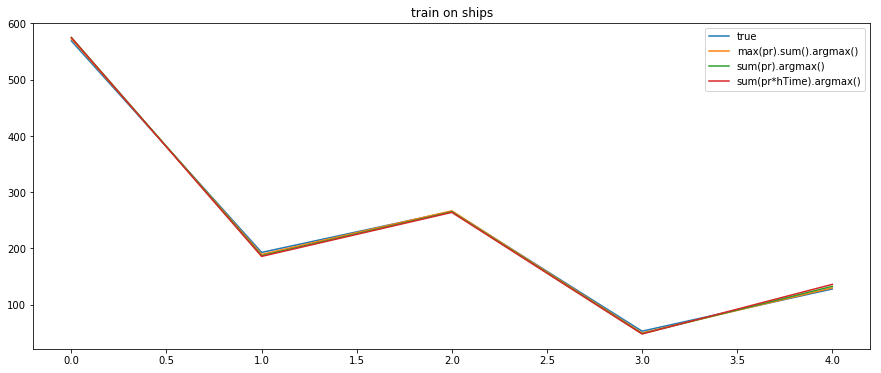

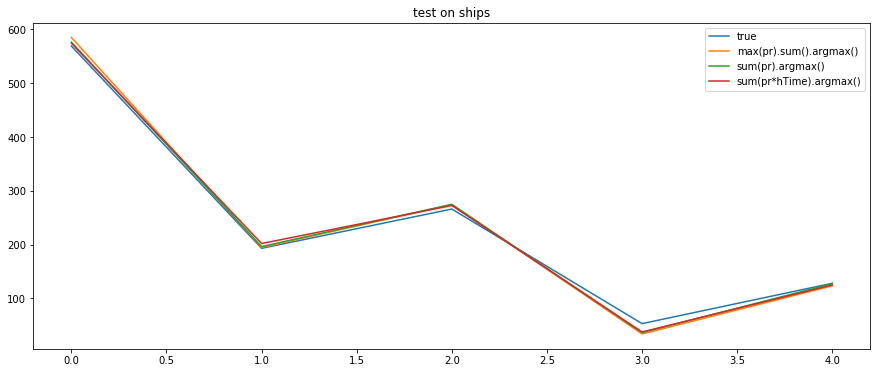

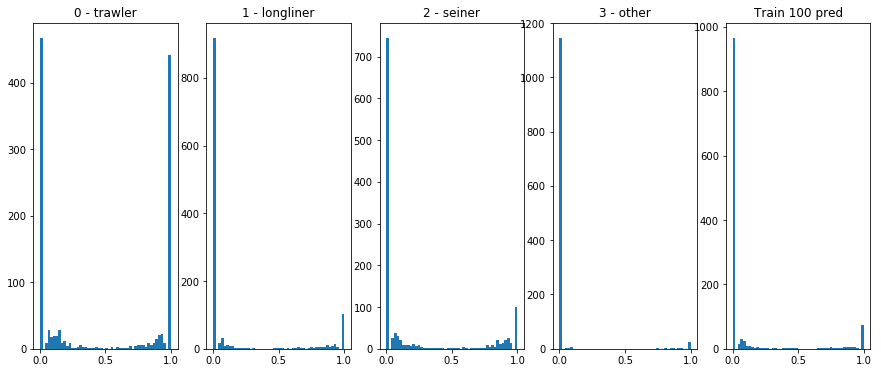

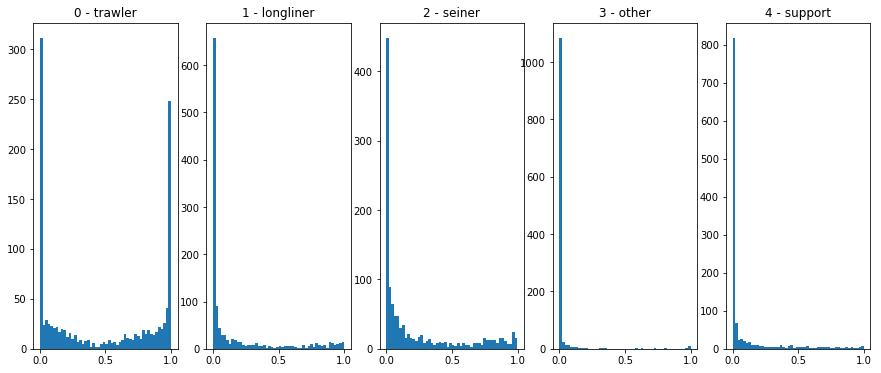

In [813]:
def pr1x5 (df) :
    temp = df.set_index(['TrackNumber','pred_y']).unstack().fillna(0.0)
    temp.columns=[0,1,2,3,4]
    return(temp)
    
train_stat = gg[['TrackNumber','pred_y','true_y']];
##print(gg.head())
#plt.hist()
train_true = train_stat.set_index(['TrackNumber','pred_y']).unstack().fillna(0.0)
train_true.columns=[0,1,2,3,4]

print 'True :', pr1x5(train_stat).sum().tolist(),'\n'

print 'Train:',np.round(pr1x5(tr000).sum(),3).tolist()
print 'Train:',np.round(np.array(pr1x5(tr100).sum(),dtype=np.float),3).tolist()
print 'Train:',np.round(pr1x5(tr110).sum(),3).tolist()
print
print 'Test :',np.round(pr1x5(te000).sum(),3).tolist()
print 'Test :',np.round(np.array(pr1x5(te100).sum(),dtype=np.float),3).tolist()
print 'Test :',np.round(pr1x5(te110).sum(),3).tolist()

plt.figure(figsize=(15,6))
plt.plot(pr1x5(train_stat).sum()); 
plt.plot(pr1x5(tr000).sum()); 
plt.plot(pr1x5(tr100).sum()); 
plt.plot(pr1x5(tr110).sum()); 

plt.legend(['true', 'max(pr).sum().argmax()', 'sum(pr).argmax()', 'sum(pr*hTime).argmax()'])

plt.title('train on ships')
plt.show()

plt.figure(figsize=(15,6))
plt.plot(pr1x5(train_stat).sum()); 
plt.plot(pr1x5(te000).sum()); 
plt.plot(pr1x5(te100).sum()); 
plt.plot(pr1x5(te110).sum()); 

plt.legend(['true', 'max(pr).sum().argmax()', 'sum(pr).argmax()', 'sum(pr*hTime).argmax()'])

plt.title('test on ships')
plt.show()

plt.figure(figsize=(15,6))
temp = pr1x5(tr100)
for ii,nn in enumerate(temp.columns) :
    plt.subplot(1,temp.shape[1],ii+1); plt.hist(temp[nn],bins=50);plt.title(str(nn)+" - "+y_class[ii])
plt.title('Train 100 pred')
plt.show()

plt.figure(figsize=(15,6))
temp = pr1x5(te100)

for ii,nn in enumerate(temp.columns) :
    plt.subplot(1,temp.shape[1],ii+1); plt.hist(temp[nn],bins=50);plt.title(str(nn)+" - "+y_class[ii])
plt.show()

plt.close()
#g0pred.head()

In [1589]:
# Построение массива с данными по списку файлов

def harvestDistance (Latitude, Longitude, R=6371.0) :
    havLa        = (0.5*(1.0-np.cos(-Latitude.diff(-1)/180.0*math.pi))).fillna(0.0)
    long1        = Longitude; long1[Longitude<0.0]  += 360.0;
    long2        = Longitude;
    long1, long2 = long1.diff(-1).fillna(0.0), long2.diff(-1).fillna(0.0)
    lLongitude   = np.array([long1.values, long2.values]).min(axis=0)
    havLo        = pd.Series(0.5*(1.0-np.cos(lLongitude/180.0*math.pi)))
    cosLa        = (np.cos(Latitude/180.0*math.pi)).fillna(0.0)
    hav          = (havLa+cosLa*cosLa.shift(-1)*havLo).fillna(0.0)
    dist         = (2*R*np.arcsin(np.sqrt(hav))).fillna(0.0)
    return (dist)
    
def buildX (file_list, nFiles=-1, maxSpeed=35.0, maxSOG=35.0, rWindow=5, nRolling=2, hTimeMin=False, hTimeMax=False, fillOK=False) :
    
    mile_sea = 1.852
    
    for ii,ffile in enumerate(file_list) :
        if ii==nFiles : break
        xx = pd.read_csv(os.path.join('../Data/VesselTracks',str(ffile)+'.csv'))
        
        ##print(ii,ffile)
        
        # Small corrections: (latitude&longitude), timing
        
        ##print 'try 100'
        xx = xx[(xx.Latitude >=-90.0)  & (xx.Latitude <= 90.0)];
        xx = xx[(xx.Longitude>=-180.0) & (xx.Longitude<=180.0)];
        
        xx['Time']  = xx[[1]]
        xx['sTime'] = np.abs(xx.Time.diff(-1)).fillna(0.0)
        xx['hTime'] = xx.sTime/3600.0
        
        if hTimeMin : 
            xx          = xx[xx.hTime>=hTimeMin]
            xx['sTime'] = np.abs(xx.Time.diff(-1)).fillna(0.0)
            xx['hTime'] = xx.sTime/3600.0
            
        xx['Distance'] = harvestDistance(xx.Latitude,xx.Longitude)
        xx['Speed']    = np.round((xx.Distance/mile_sea/xx.hTime).fillna(0.0),2)  # speed in knots
        
        
        # Small correction: speed outline ->> Latitude&Longitude
        
        if (len(xx.Speed[xx.Speed>maxSpeed])>0) :
            ##print 'try change'
            xy = xx.Speed.values;
            rrWindow = 10
            ##print 'try change', xx.TrackNumber[0], len(xy), len(xy[xy>maxSpeed]), xy[xy>maxSpeed].min(), xy[xy>maxSpeed].max()
            
            Latitude   = xx.Latitude.values
            Longitude  = xx.Longitude.values
            Longitude[Longitude<=-100.0]  += 360.0  # ???? danger operation
            rLatitude  = xx.Latitude.rolling(window=rrWindow, min_periods=1).median().values
            rLongitude = xx.Longitude.rolling(window=rrWindow, min_periods=1).median().values
            Latitude[xy>maxSpeed]   = rLatitude[xy>maxSpeed]
            Longitude[xy>maxSpeed]  = rLongitude[xy>maxSpeed]
            Longitude[Longitude>180.0]  = xx.Longitude[Longitude>180.0] #- 360.0
            distance   = harvestDistance(pd.Series(Latitude),pd.Series(Longitude))
            speed      = np.round((distance/mile_sea/xx.hTime).fillna(0.0),2)  # speed in knots
            if  len(speed>maxSpeed)==0 :
                ##print 'change'
                xx.Latitude  = Latitude
                xx.Longitude = Longitude
                xx.Distance  = distance
                xx.Speed     = speed
            else :
                ##print 'deleting'
                xx              = xx[xx.Speed<=maxSpeed]
                sTime           = np.abs(xx.Time.diff(-1)).fillna(0.0)
                xx['sTime']     = sTime
                xx['hTime']     = xx.sTime/3600.0
                xx['Distance']  = harvestDistance(xx.Latitude,xx.Longitude)
                xx['Speed']     = np.round((xx.Distance/mile_sea/xx.hTime).fillna(0.0),2)  # speed in knots
        
        xx.loc[xx.Longitude>180,'Longitude'] -= 360.0
        xx['Speed']    = np.round(np.clip(xx.Speed,0.0,maxSpeed),2)
        
        if hTimeMax : 
            xx.sTime[xx.hTime<=hTimeMax] = 0.0
            xx.hTime[xx.hTime<=hTimeMax] = 0.0
        
        # rolling Speeds (double, triple and etc)
        for jj in range(1,nRolling+1) :
            suffix    = '' if jj==1 else str(jj)
            rSOG      = xx.SOG.rolling(window=rWindow*jj, min_periods=1).mean()
            rSOGmd    = xx.SOG.rolling(window=rWindow*jj, min_periods=1).median()
            rSpeed    = xx.Speed.rolling(window=rWindow*jj, min_periods=1).mean()
            rDistance = xx.Distance.rolling(window=rWindow*jj, min_periods=1).mean()
            rTime     = xx.hTime.rolling(window=rWindow*jj, min_periods=1).mean()
            rDTSpeed = (rDistance/rTime/mile_sea).fillna(0.0)
            
            xx['rSpeed'+suffix] = np.round(np.clip(rSpeed,0.0,maxSpeed),2)
            xx['rSOG'+suffix]   = np.round(np.clip(rSOG,0.0,maxSpeed),2)
            xx['rSOGmd'+suffix] = np.round(np.clip(rSOGmd,0.0,maxSpeed),2)
            xx['rDTSpeed'+suffix] = np.round(np.clip(rDTSpeed,0.0,maxSpeed),2)

        xx.loc[xx.SOG<0.0,'SOG']    = xx.loc[xx.SOG<0.0,'rSOG']
            
        if fillOK : xx = xx.fillna(fillOK)

        if (ii==0) : resAll = xx.copy()
        else       : resAll = resAll.append(xx.copy())

    ##print(trainAll.shape)
    return (resAll)

def buildY (file_list, y_classes) :
    
    trainIndex=file_list.copy()
    trainIndex['y'] = np.array(map(y_classes.index,trainIndex.typing.tolist()))
    return(trainIndex)

In [1590]:
aala = pd.Series([-1.0,1.0,-1.0,1.0,0.0])
aalo = pd.Series([0.0,0.0,0.0,0.0,0.0])
aalo = pd.Series([-1.0,1.0,-1.0,1.0,0.0])
aalo = pd.Series([-179.0,179.0,-179.0,179.0,180.0])
aala = pd.Series([ 1.0,1.0,1.0,1.0,0.0])
aala = pd.Series([-1.0,-1.0,-1.0,-1.0,0.0])
aala = pd.Series([-90.0,90.0,-90.0,90.0,0.0])
aadd=harvestDistance(aala,aalo)
print(aadd)
del aadd

0    20015.086796
1    20015.086796
2    20015.086796
3    10007.543398
4        0.000000
dtype: float64


/home/boba/anaconda2/envs/tensorflow-gpu/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


35.0 7580 6591 1523.70376083 1427.78544588 (6591, 26)


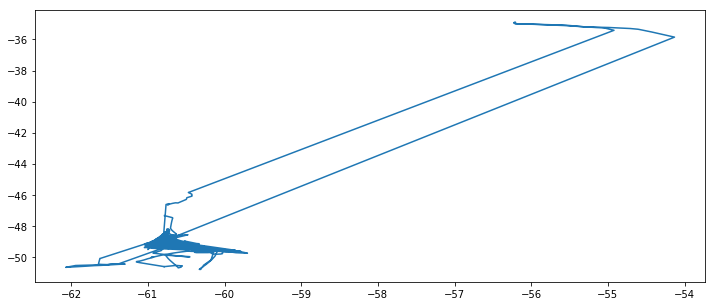

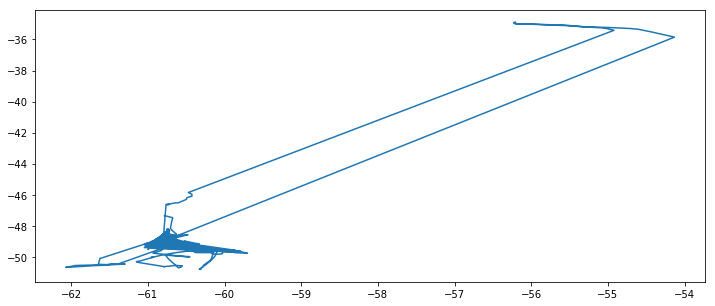

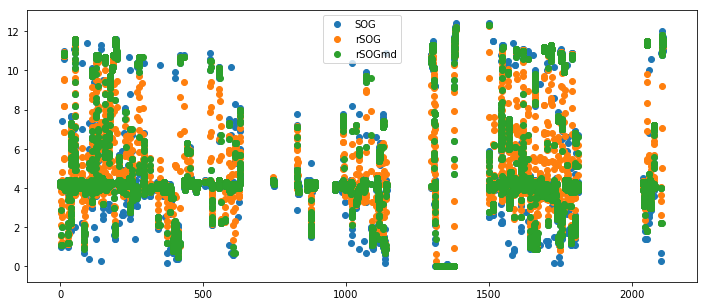

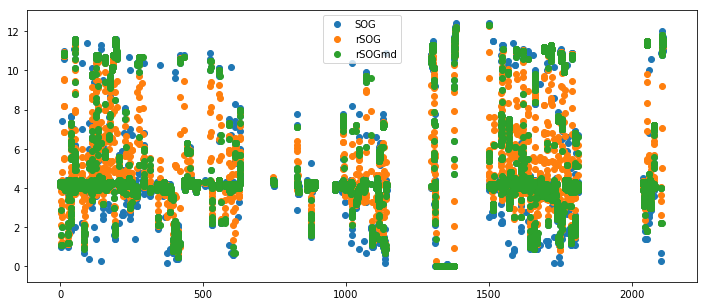

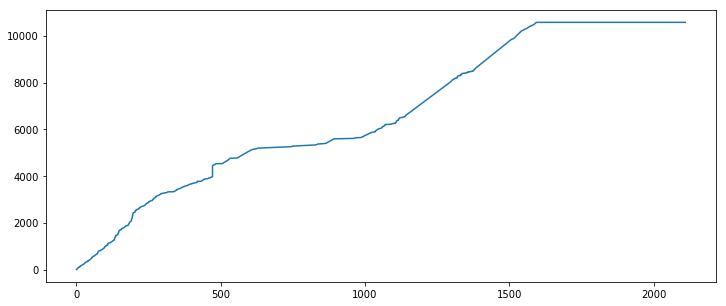

TrackNumber
100080      2
100093      1
100144      8
100161      4
100175      3
100262     19
100277      9
100287      2
100305      2
100321      7
100370      4
100380      4
100383      2
100448     11
100457      1
100464      1
100528      2
100539     45
100580      4
100595      2
100625     29
100639      3
100682     12
100821     27
100846    815
100963      1
101030      5
101096      1
101099     18
101169      6
Name: Speed, dtype: int64

In [1592]:
xxnn = 100639
xxyy = buildX([xxnn],hTimeMin=3.0/3600.0)
aayy = trainAll[trainAll.TrackNumber==xxnn]
##print aayy.describe()
##print xxyy.describe()
print xxyy.Speed.max(), len(aayy), len(xxyy), aayy.Distance.max(), xxyy.Distance.max(), xxyy.shape
plt.figure(figsize=(12,5)); plot_trass_fl(aayy)
plt.figure(figsize=(12,5)); plot_trass_fl(xxyy)
plt.figure(figsize=(12,5)); plot_trass_sp(aayy)
plt.figure(figsize=(12,5)); plot_trass_sp(xxyy)
plt.figure(figsize=(12,5)); plot_dh(xxyy)
del xxyy, aayy,xxnn
trainAll[trainAll.Speed>=35.0].Speed.groupby(trainAll.TrackNumber).count()[:30]

In [1389]:
def plot_trass_fl (df) :
    plt.plot(df['Longitude'].values.tolist(),df['Latitude'].values.tolist());
    plt.show();
def plot_trass_sp (df) :
    axx = df['hTime'].cumsum().values.tolist()
    plt.scatter(axx,df['SOG']);    legenda  = ['SOG']
    plt.scatter(axx,df['rSOG']);   legenda += ['rSOG']
    plt.scatter(axx,df['rSOGmd']); legenda += ['rSOGmd']
    #plt.scatter(axx,df['rSpeed']); legenda += ['rSpeed']
    #plt.plot(df['rDTSpeed']); legenda += ['rDTSpeed']
    #plt.plot(df['Speed']); legenda += ['Speed']
    plt.legend(legenda)
    plt.show();

def plot_dist (df) :
    plt.plot(df['Distance'].cumsum());    legenda  = ['Distance']
    plt.legend(legenda)
    plt.show();
    
def plot_hours (df) :
    plt.plot(df['hTime'].cumsum());    legenda  = ['hTime']
    plt.legend(legenda)
    plt.show();
                
def plot_dh (df) :
    plt.plot(df['hTime'].cumsum().values.tolist(),df['Distance'].cumsum().values.tolist());
    plt.show();
    
def plot_yh (df, pry) :
    ##print(pry)
    pryr = pd.Series(np.array(np.round(pry[:,0],0),dtype=np.int32)).rolling(window=9, min_periods=1,center=True).median()
    print(pryr.unique())
    
    pryr = np.round(pryr,0)
    
    print('res:',[(xx,yy.count()) for xx,yy in pd.Series(pry[:,0]).groupby(pry[:,0])])
    print('rol:',[(xx,yy.count()) for xx,yy in pryr.groupby(pryr)])
    ##print(pryr.head())
    
    plt.plot(df['hTime'].cumsum().values.tolist(),pry);
    plt.plot(df['hTime'].cumsum().values.tolist(),pryr);
    
    plt.show();


In [1390]:
print trainIndex.y.groupby(trainIndex.y).count()
[(xx,yy.count()) for xx,yy in trainIndex.y.groupby(trainIndex.y)]

y
0    569
1    193
2    266
3     53
4    128
Name: y, dtype: int64


[(0, 569), (1, 193), (2, 266), (3, 53), (4, 128)]

In [1391]:
def plotting (inns, trackIndex, trainAll, pred_y) :
    
    for inn in inns.values.tolist() :

        nn   = trainIndex.loc[trainIndex.trackfile==inn,'typing'].values
        temp = trainAll.loc[trainAll.TrackNumber==inn]

        print('*'*90)
        print(str(inn)+' - '+nn, '-'*40)
        print('Distance: {} hTime: {} Distance(max)={} Points={}'.format(temp['Distance'].sum(),temp['hTime'].sum(),temp['Distance'].max(),len(temp)))
        print('SOG: \tmean={} median={} minmax = {}-{}'.format(temp['SOG'].mean(),temp['SOG'].median(),temp['SOG'].min(),temp['SOG'].max()))
        print('rSOG: \tmean={} median={} minmax = {}-{}'.format(temp['rSOG'].mean(),temp['rSOG'].median(),temp['rSOG'].min(),temp['rSOG'].max()))
        print('Speed: \tmean={} median={} minmax = {}-{}'.format(temp['Speed'].mean(),temp['Speed'].median(),temp['Speed'].min(),temp['Speed'].max()))
        print('rSp: \tmean={} median={} minmax = {}-{}'.format(temp['rSpeed'].mean(),temp['rSpeed'].median(),temp['rSpeed'].min(),temp['rSpeed'].max()))
        
        if 1 :
            temp1  = pred_y[trainAll.TrackNumber==inn]
            temp2  = np.reshape(temp1.argmax(axis=1),(temp1.shape[0],1));
            plt.figure(figsize=(15,3)); plt.title(str(inn)+' - '+nn+' predictions'); plot_yh(temp,temp2)

        plt.figure(figsize=(15,5)); plt.title(str(inn)+' - '+nn+' Speeds'); plot_trass_sp(temp)

        plt.figure(figsize=(15,3)); plt.title(str(inn)+' - '+nn+' Distance-Time'); plot_dh(temp)
        
        plt.figure(figsize=(15,3)); plt.title(str(inn)+' - '+nn); plot_trass_fl(temp)


        #plt.figure(figsize=(15,5)); plt.title(str(inn)+' - '+nn); plot_dist(temp)
        #plt.figure(figsize=(15,5)); plt.title(str(inn)+' - '+nn); plot_hours(temp)

In [1392]:
#trainAll_ = buildX(train_list['trackfile'].values.tolist(), nFiles=101, hTimeMin=5.0/3600, rWindow=5);

   trackfile     typing  y
0     100047    trawler  0
1     100070  longliner  1
2     100080     seiner  2
3     100093      other  3
4     100144    trawler  0
(14, [103944, 109405, 109903, 110311, 110948, 112290, 113104, 113835, 115271, 120990, 124127, 129382, 131935, 132352])
******************************************************************************************
(array(['103944 - trawler'], dtype=object), '----------------------------------------')
Distance: 630.34358035 hTime: 1305.06 Distance(max)=7.37638878748 Points=403
SOG: 	mean=3.75062034739 median=3.3 minmax = 0.0-9.1
rSOG: 	mean=3.78650124069 median=3.26 minmax = 0.0-8.66
Speed: 	mean=3.71248138958 median=3.23 minmax = 0.0-35.0
rSp: 	mean=3.74642679901 median=3.21 minmax = 0.0-12.86
[ 2.   1.   0.   0.5]
('res:', [(0, 249), (1, 28), (2, 126)])
('rol:', [(0.0, 238), (1.0, 34), (2.0, 131)])


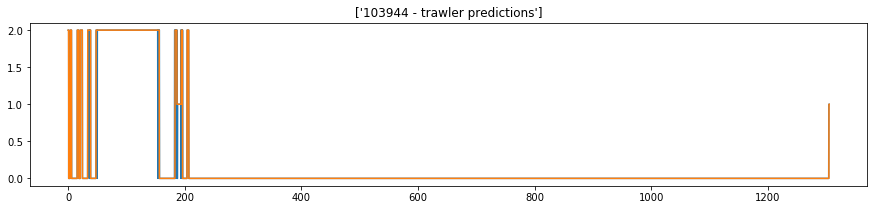

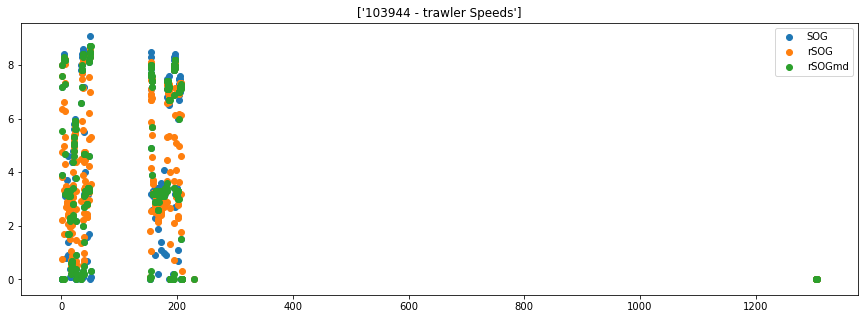

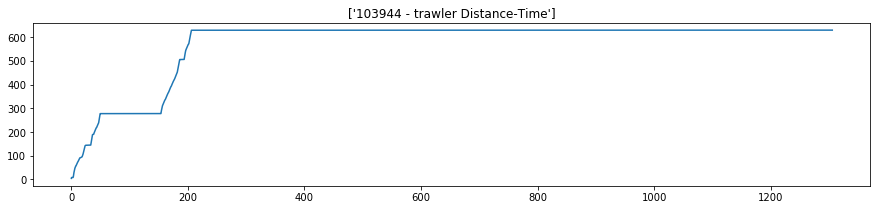

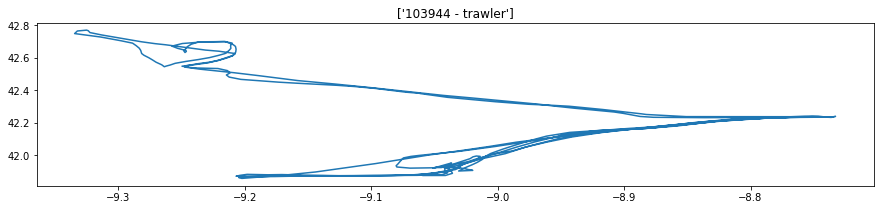

******************************************************************************************
(array(['109405 - trawler'], dtype=object), '----------------------------------------')
Distance: 40.0508517298 hTime: 205.875833333 Distance(max)=5.8341796746 Points=13
SOG: 	mean=6.0 median=9.2 minmax = 0.0-10.1
rSOG: 	mean=4.94461538462 median=5.56 minmax = 0.0-9.6
Speed: 	mean=5.50153846154 median=9.15 minmax = 0.0-9.92
rSp: 	mean=4.79538461538 median=5.59 minmax = 0.0-9.51
[ 2.  1.  0.]
('res:', [(0, 10), (2, 3)])
('rol:', [(0.0, 11), (1.0, 1), (2.0, 1)])


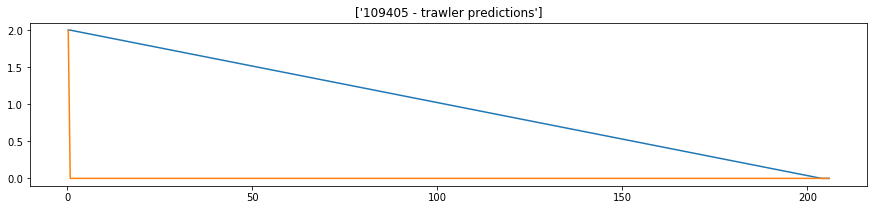

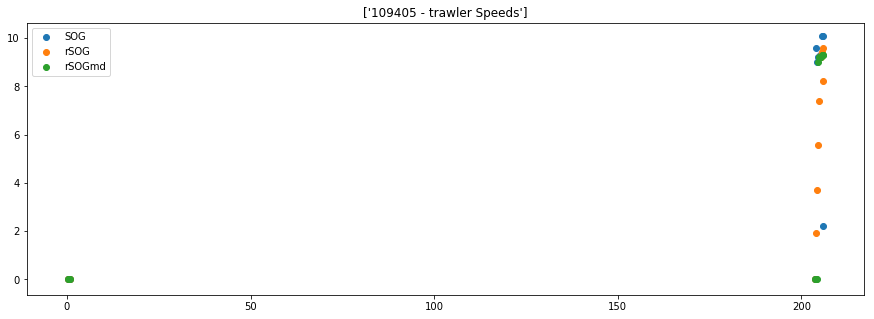

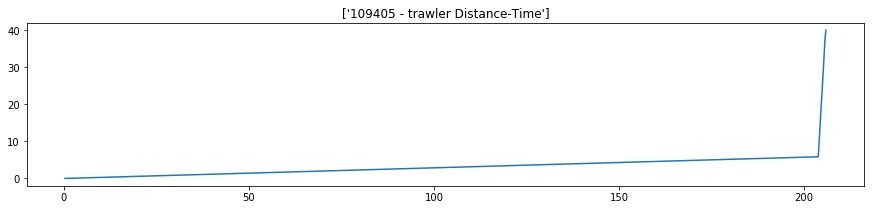

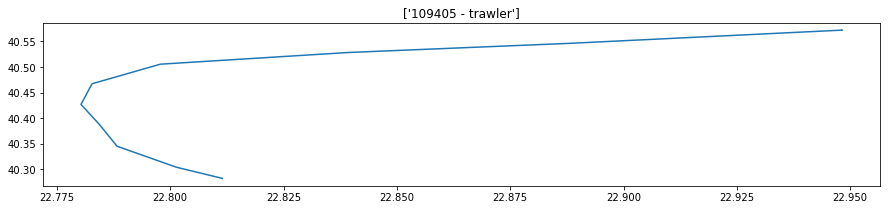

******************************************************************************************
(array(['109903 - trawler'], dtype=object), '----------------------------------------')
Distance: 46173.108315 hTime: 1834.5 Distance(max)=12438.7998649 Points=1944
SOG: 	mean=4.87942386831 median=3.3 minmax = 0.0-10.5
rSOG: 	mean=4.88739197531 median=3.45 minmax = 0.0-9.94
Speed: 	mean=4.48527263374 median=3.25 minmax = 0.0-35.0
rSp: 	mean=4.49485082305 median=3.27 minmax = 0.0-19.48
[ 0.  2.  1.]
('res:', [(0, 1511), (1, 143), (2, 289), (4, 1)])
('rol:', [(0.0, 1609), (1.0, 112), (2.0, 223)])


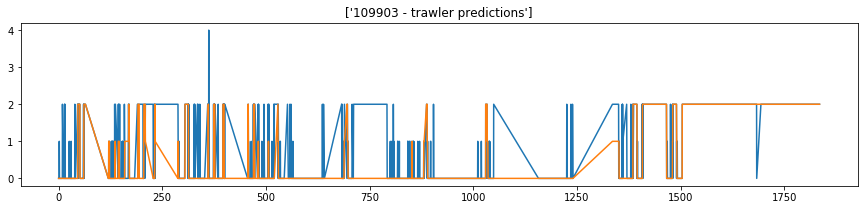

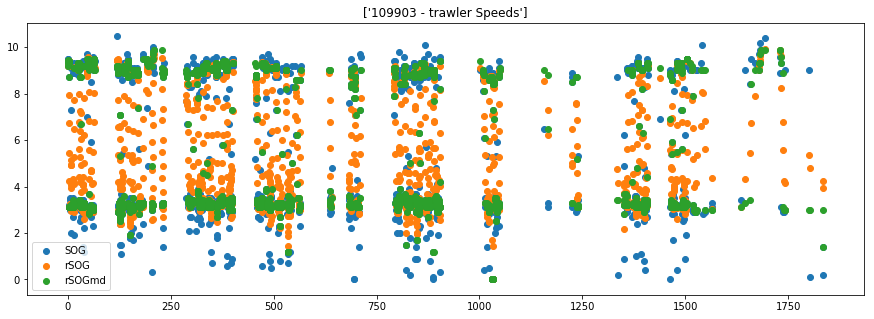

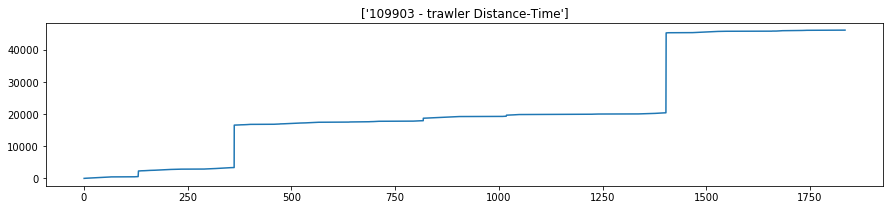

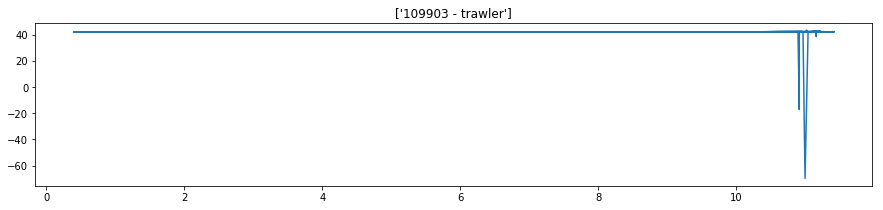

******************************************************************************************
(array(['110311 - trawler'], dtype=object), '----------------------------------------')
Distance: 17044.8718114 hTime: 1604.22972222 Distance(max)=5247.42817769 Points=2240
SOG: 	mean=3.89379464286 median=3.2 minmax = 0.0-11.2
rSOG: 	mean=3.88702678571 median=3.01 minmax = 0.0-9.94
Speed: 	mean=3.62664732143 median=1.76 minmax = 0.0-35.0
rSp: 	mean=3.62239285714 median=2.405 minmax = 0.0-15.01
[ 0.  1.  4.]
('res:', [(0, 1727), (1, 492), (2, 14), (4, 7)])
('rol:', [(0.0, 1723), (1.0, 512), (4.0, 5)])


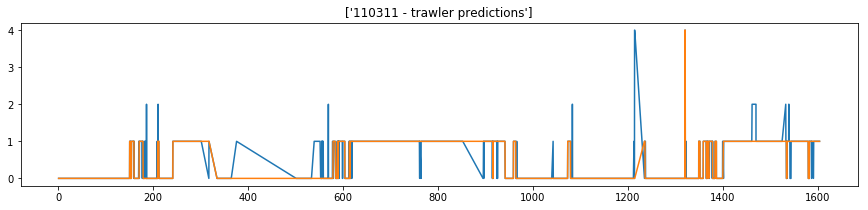

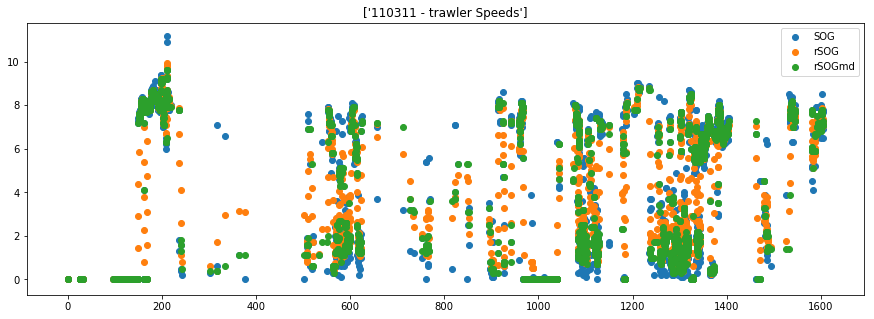

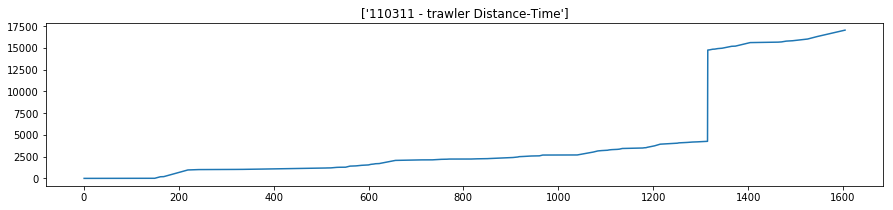

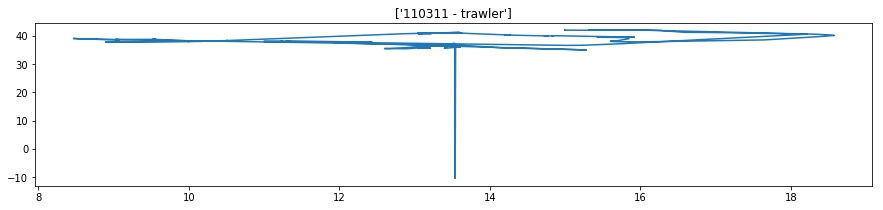

******************************************************************************************
(array(['110948 - trawler'], dtype=object), '----------------------------------------')
Distance: 2.62484367125 hTime: 3.25916666667 Distance(max)=2.43590910725 Points=13
SOG: 	mean=0.707692307692 median=0.0 minmax = 0.0-7.3
rSOG: 	mean=1.48923076923 median=0.02 minmax = 0.0-7.3
Speed: 	mean=0.381538461538 median=0.0 minmax = 0.0-4.62
rSp: 	mean=0.85 median=0.0 minmax = 0.0-4.62
[ 0.]
('res:', [(0, 10), (1, 3)])
('rol:', [(0.0, 13)])


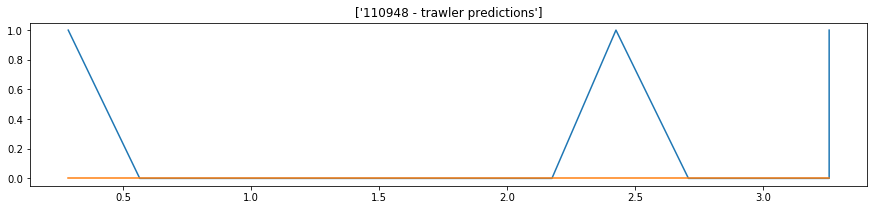

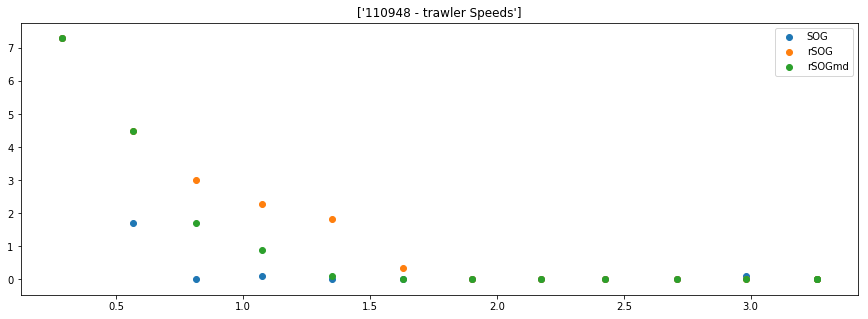

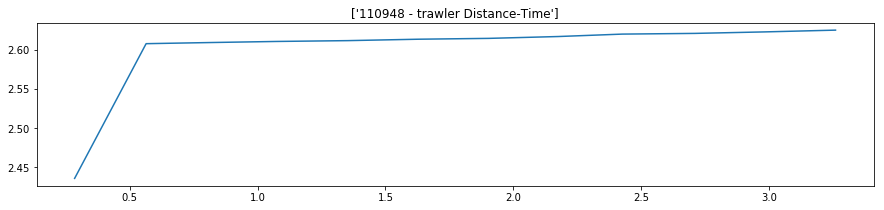

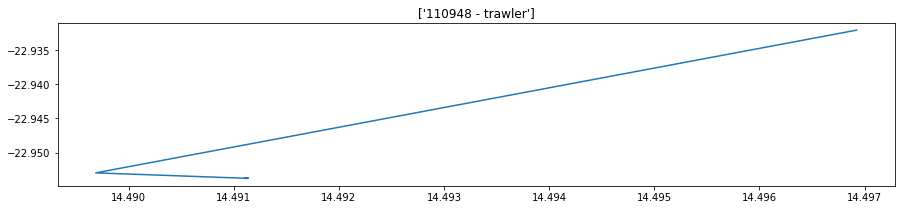

******************************************************************************************
(array(['112290 - trawler'], dtype=object), '----------------------------------------')
Distance: 2244.39296038 hTime: 2177.00388889 Distance(max)=69.2143240657 Points=670
SOG: 	mean=4.50880597015 median=4.2 minmax = 0.0-10.4
rSOG: 	mean=4.49491044776 median=5.0 minmax = 0.0-9.66
Speed: 	mean=3.62310447761 median=1.94 minmax = 0.0-10.15
rSp: 	mean=3.61264179104 median=3.89 minmax = 0.0-9.04
[ 0.  2.]
('res:', [(0, 364), (2, 306)])
('rol:', [(0.0, 342), (2.0, 328)])


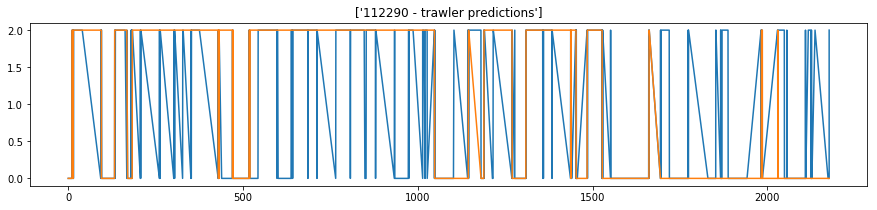

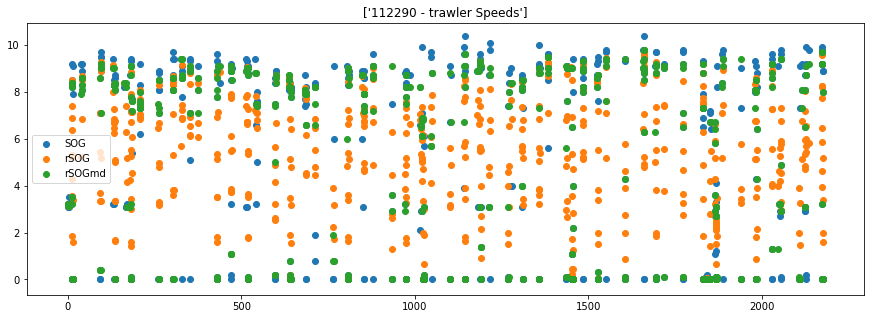

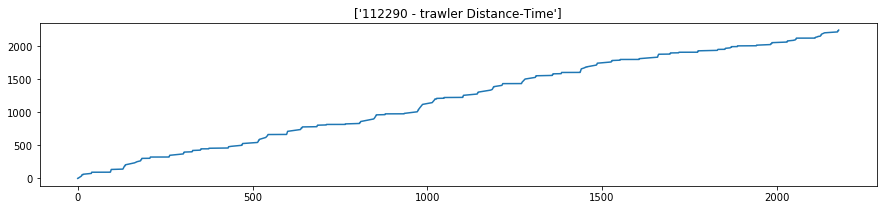

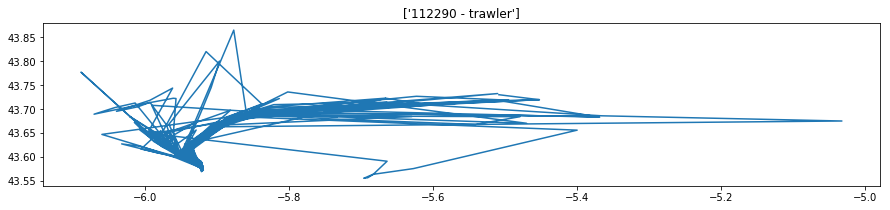

******************************************************************************************
(array(['113104 - trawler'], dtype=object), '----------------------------------------')
Distance: 1328.57106175 hTime: 2192.82694444 Distance(max)=37.6481694961 Points=530
SOG: 	mean=3.35320754717 median=3.1 minmax = 0.0-12.0
rSOG: 	mean=3.36194339623 median=3.22 minmax = 0.0-9.94
Speed: 	mean=2.79850943396 median=2.98 minmax = 0.0-11.26
rSp: 	mean=2.80858490566 median=2.85 minmax = 0.0-9.87
[ 0.  2.]
('res:', [(0, 381), (2, 149)])
('rol:', [(0.0, 404), (2.0, 126)])


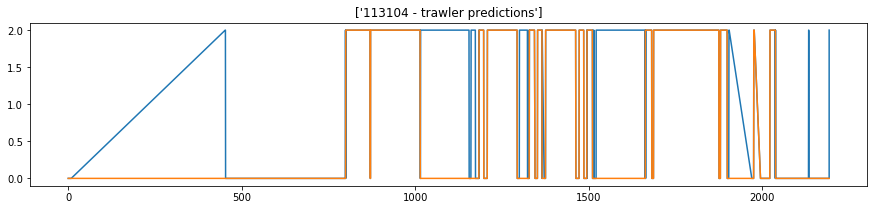

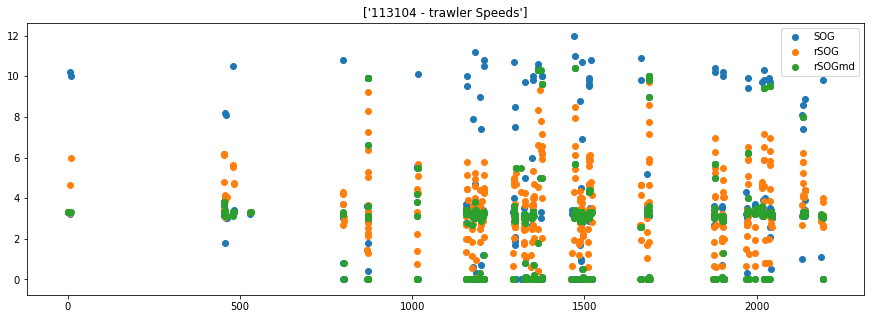

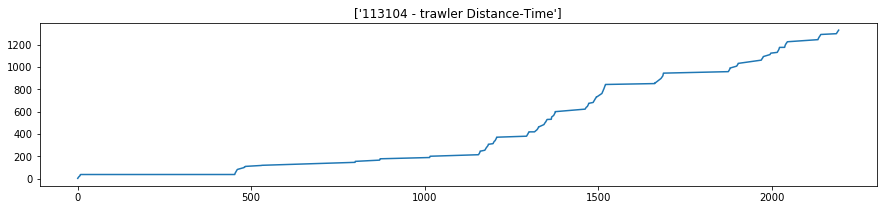

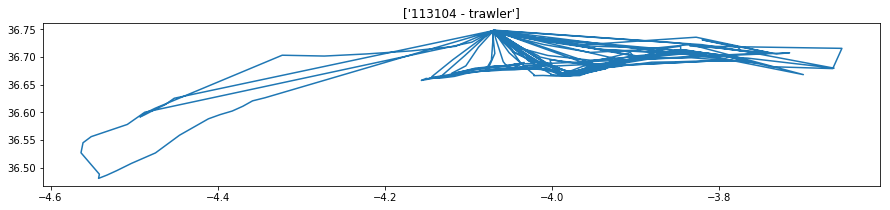

******************************************************************************************
(array(['113835 - trawler'], dtype=object), '----------------------------------------')
Distance: 1022.61773286 hTime: 301.534444445 Distance(max)=950.983888877 Points=257
SOG: 	mean=1.17315175097 median=0.1 minmax = 0.0-10.3
rSOG: 	mean=1.10108949416 median=0.08 minmax = 0.0-10.14
Speed: 	mean=1.0826848249 median=0.04 minmax = 0.0-10.33
rSp: 	mean=1.04214007782 median=0.05 minmax = 0.0-10.16
[ 0.  4.]
('res:', [(0, 208), (4, 49)])
('rol:', [(0.0, 216), (4.0, 41)])


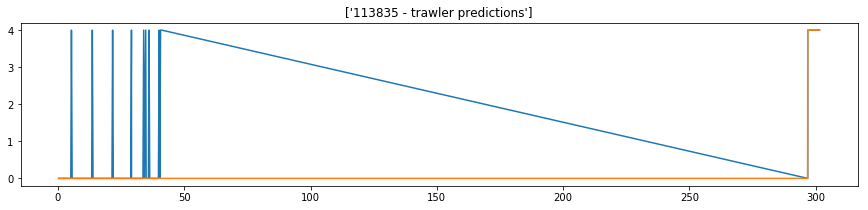

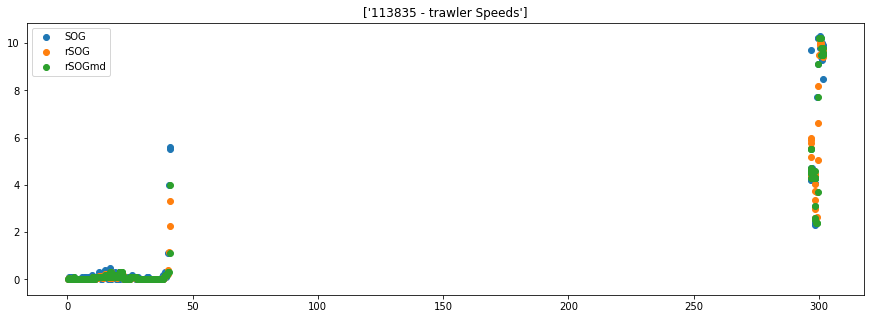

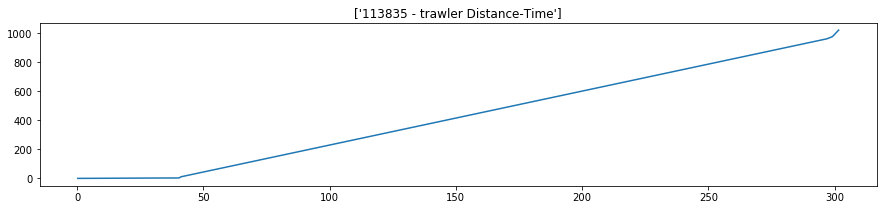

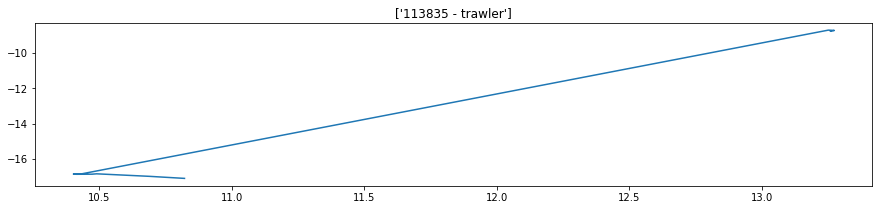

******************************************************************************************
(array(['115271 - trawler'], dtype=object), '----------------------------------------')
Distance: 40015.9828411 hTime: 2179.82388889 Distance(max)=14330.0452497 Points=6108
SOG: 	mean=3.40821872954 median=0.4 minmax = 0.0-12.9
rSOG: 	mean=3.40836607728 median=1.26 minmax = 0.0-12.02
Speed: 	mean=2.93664210871 median=0.315 minmax = 0.0-35.0
rSp: 	mean=2.93663883432 median=0.75 minmax = 0.0-19.43
[ 0.  2.  1.]
('res:', [(0, 4243), (1, 1), (2, 1864)])
('rol:', [(0.0, 4249), (1.0, 1), (2.0, 1858)])


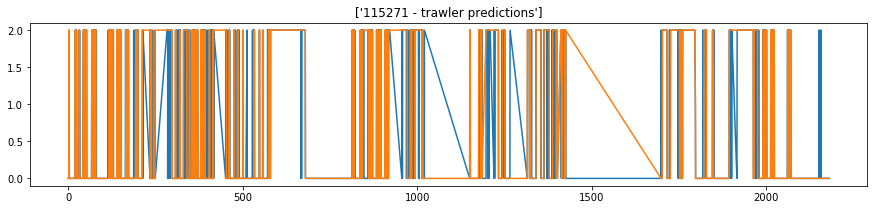

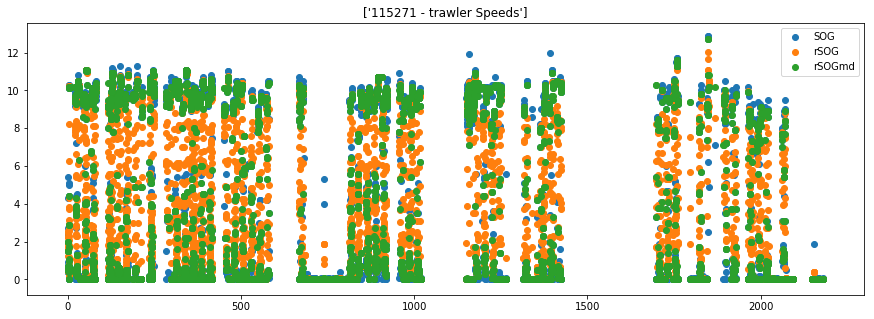

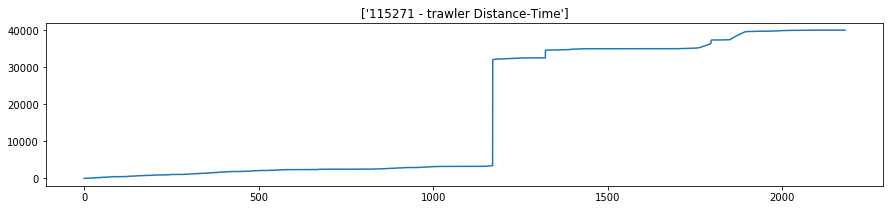

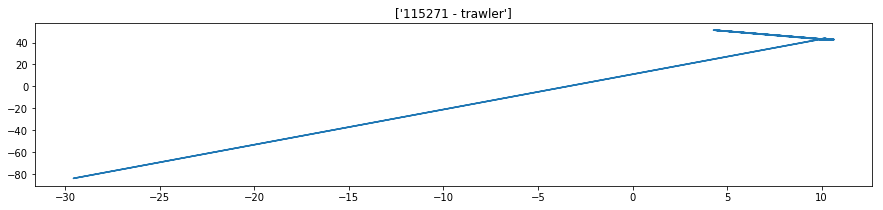

******************************************************************************************
(array(['120990 - trawler'], dtype=object), '----------------------------------------')
Distance: 7925.85603894 hTime: 2201.62 Distance(max)=806.912995232 Points=1726
SOG: 	mean=4.77050984936 median=3.0 minmax = 0.0-9.2
rSOG: 	mean=4.77256662804 median=4.22 minmax = 0.0-9.18
Speed: 	mean=4.39102549247 median=2.68 minmax = 0.0-35.0
rSp: 	mean=4.39716685979 median=3.46 minmax = 0.0-16.51
[ 1.   0.   0.5]
('res:', [(0, 1326), (1, 399), (2, 1)])
('rol:', [(0.0, 1370), (1.0, 356)])


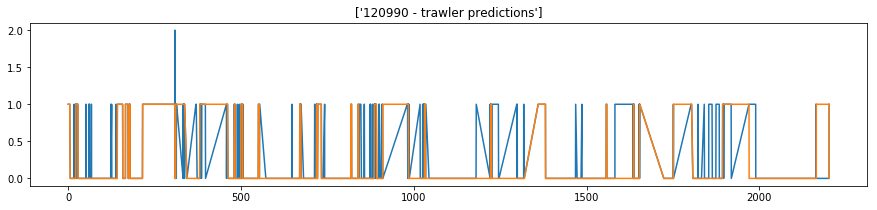

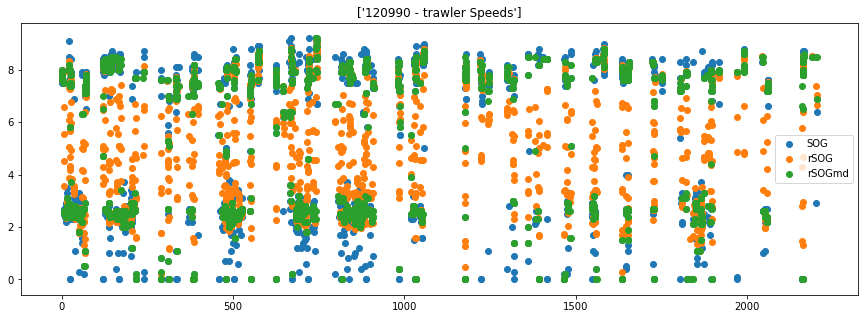

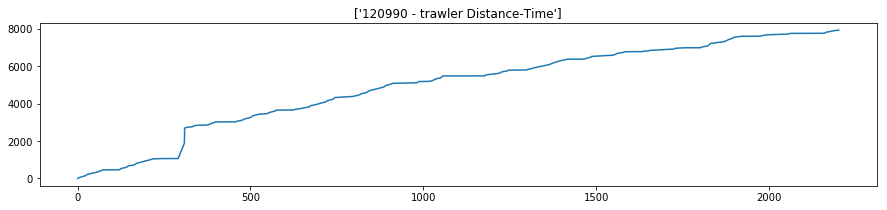

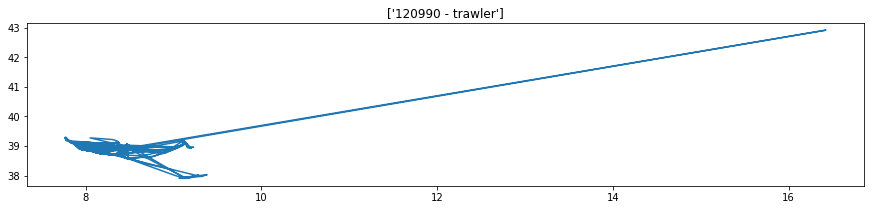

In [1395]:
##trainAll.TrackNumber.head()
print(trainIndex.head())

y   = 0
ypr = 0.7

yy_pred0 = pd.DataFrame(pred_y).groupby(trainAll.TrackNumber).sum(); ##print(yy_pred0.head())
yy_pred1 = yy_pred0.sum(axis=1); #print(yy_pred1.head())
yy_pred0_columns = yy_pred0.columns
for ii in yy_pred0_columns :
    yy_pred0[ii] /= yy_pred1
yy_pred0['yy'] = 0.0
yy_pred0['y']  = trainIndex.set_index('trackfile').y
for ii in yy_pred0_columns :
    yy_pred0.loc[yy_pred0.y==ii,'yy'] = yy_pred0.loc[yy_pred0.y==ii,ii]
yy_pred0 = yy_pred0.reset_index()
##print(yy_pred0.head())
inns = yy_pred0[(yy_pred0.y==y) & (yy_pred0.yy<=ypr)].TrackNumber
print(len(inns),inns.head(20).values.tolist())


plotting(inns[:10],trainIndex,trainAll,pred_y)

In [960]:
8000.0/(14*1.852)/24.0

12.856114367993419

In [999]:
2*math.pi*6371

40030.173592041145

In [1144]:
##nn   = trainIndex.loc[trainIndex.trackfile==inn,'typing'].values
temp0  = trainAll.loc[trainAll.TrackNumber==100854]
temp1  = pred_y[trainAll.TrackNumber==100854]
temp2  = np.reshape(temp1.argmax(axis=1),(temp1.shape[0],1)); print(temp2.shape)
print(temp1.shape,temp.shape)
temp   = np.hstack([temp1,temp2,temp0.values])
temp10 = pd.DataFrame(temp,columns=range(temp1.shape[1])+['y']+temp0.columns.tolist())
temp10.tail()



(412, 1)
((412, 5), (412, 29))


,0,1,2,3,4,y,Chlorophyll Concentration,Distance,Eastward Water Velocity,Latitude,...,Time(seconds),TrackNumber,Water Surface Elevation,hTime,oceanic depth,rDTSpeed,rSOG,rSOGmd,rSpeed,sTime
407,0.438752,0.548424,0.012572,0.000194,0.000057,1.0,0.6317,56.999759,0.10,52.101043,...,6709266.0,100854.0,-1.50,3.542500,-28.0,8.44,8.68,8.7,7.93,12753.0
408,0.147233,0.849245,0.003224,0.000281,0.000017,1.0,0.7536,10.532117,-0.02,52.137578,...,6722019.0,100854.0,-1.47,0.694722,-90.0,8.39,8.54,8.7,7.77,2501.0
409,0.342819,0.644803,0.012149,0.000211,0.000018,1.0,0.8754,38.069526,0.01,52.149630,...,6724520.0,100854.0,-1.46,2.617222,-125.0,8.21,8.42,8.4,7.58,9422.0
410,0.764154,0.219753,0.015817,0.000241,0.000036,0.0,0.8874,47.087229,0.12,52.199865,...,6733942.0,100854.0,-1.41,3.277222,-208.0,8.05,8.22,8.3,7.46,11798.0
411,0.356260,0.637619,0.005954,0.000062,0.000105,1.0,0.3741,0.000000,0.08,52.266240,...,6745740.0,100854.0,-1.41,0.000000,-151.0,8.14,7.96,7.9,6.50,0.0
